# Install Package

In [1]:
%pip install scipy seaborn scikit-learn tensorflow tensorflow_datasets 
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install sklearn
%pip install xgboost
%pip install gensim
%pip install nltk
%pip install tqdm
%pip install pyvi
%pip install tensorflow
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... - error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sk

In [2]:
# !rm -rf /kaggle/working/*

In [3]:
## Imports
from tqdm import tqdm
import os
import time
import re
import joblib
import torch
import logging
import nltk
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, log_loss
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
from pyvi import ViTokenizer, ViPosTagger
from tqdm import tqdm
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# ref: https://www.kaggle.com/code/eswarbabu88/toxic-comment-glove-logistic-regression
# need to use glove_model from above
# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Cute processing functions

In [4]:
# ===========================================================================================
# Tạo class Logger
class MyLogger:
    def __init__(self, log_file='app.log'):
        self.log_file = log_file
        self._initialize_logger()

    def _initialize_logger(self):
        # Check if the log file already exists; if so, append to it
        if os.path.exists(self.log_file):
            file_mode = 'a'  # Append mode
        else:
            file_mode = 'w'  # Write mode (create new file)

        # Create a logger
        self.logger = logging.getLogger()
        self.logger.setLevel(logging.INFO)  # Set logging level to INFO

        # Create file handler
        file_handler = logging.FileHandler(self.log_file, mode=file_mode, encoding='utf-8')
        file_handler.setLevel(logging.INFO)  # Ensure the file handler logs INFO and above

        # Create console handler
        console_handler = logging.StreamHandler()
        console_handler.setLevel(logging.INFO)  # Ensure the console handler logs INFO and above

        # Set up the logging format
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        console_handler.setFormatter(formatter)

        # Remove existing handlers to avoid duplicates
        if self.logger.hasHandlers():
            self.logger.handlers.clear()

        # Add handlers to the logger
        self.logger.addHandler(file_handler)
        self.logger.addHandler(console_handler)

    def log_message(self, message):
        self.logger.info(message)

    def change_log_file(self, new_log_file):
        """Change the log file and reinitialize the logger."""
        self.log_file = new_log_file
        self._initialize_logger()  # Reinitialize logger with the new log file

# ============================================================================================
# danh sách các biến toàn cục
logger = MyLogger()

# Enable/Disable tokenizers parallelism to avoid the warning
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# ============================================================================================
# Danh sách các hàm xử lý
# ============================================================================================
# Load the stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stop_words(text):
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Join the filtered words back into a string
    return ' '.join(filtered_words)

def preprocess_text(text):
    # Step 1: Remove URLs
    text = re.sub(r'http\S+|https?://\S+|www\.\S+', '', text)
    
    # Step 2: Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Step 3: Remove angle brackets
    text = re.sub(r'<.*?>+', '', text)
    
    # Step 4: Remove newlines, tabs, carriage returns, form feeds, backspace characters
    text = re.sub(r'\n|\t|\r|\f|\b', '', text)
    
    # Step 5: Remove words that contain numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Step 6: Remove any non-alphanumeric characters, then make lowercase
    text = re.sub(r'\W+', ' ', text).lower().strip()
    
    # Step 7: Tokenize the Vietnamese text using ViTokenizer
    text = ViTokenizer.tokenize(text)
    
    text = remove_stop_words(text)
    
    return text

def load_data(file_path):
    # Load the dataset
    df_ds = pd.read_csv(file_path)

    # First, split into train and test sets (80% train, 20% test)
    train_essays, test_essays = train_test_split(df_ds, test_size=0.2, random_state=42)

    # Then, split the train set into train and validation sets (67% train, 33% validation)
    train_essays, val_essays = train_test_split(train_essays, test_size=0.33, random_state=42)
    
    return df_ds, train_essays, test_essays, val_essays

def compute_metrics(preds, labels):
    # Convert probabilities to binary predictions
    binary_preds = (preds >= 0.5).astype(int)

    # Compute ROC AUC score
    auc = roc_auc_score(labels, preds)

    # Other metrics with zero_division set to handle undefined metrics
    accuracy = accuracy_score(labels, binary_preds)
    precision = precision_score(labels, binary_preds, zero_division=0)  # Use zero_division=0 to avoid warnings
    recall = recall_score(labels, binary_preds)
    f1 = f1_score(labels, binary_preds, zero_division=0)  # Use zero_division=0 to avoid warnings

    return {"roc_auc": auc, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def compute_metrics_bert(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using softmax
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    
    # Get the predicted class by selecting the class with the highest probability
    preds = np.argmax(probs, axis=-1)
    
    # Compute ROC AUC score using probabilities of the positive class (class 1)
    if len(np.unique(labels)) > 1:  # Ensure there are both classes present for AUC computation
        auc = roc_auc_score(labels, probs[:, 1])
    else:
        auc = float('nan')  # AUC is not defined if only one class is present
    
    # Compute other metrics
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds, zero_division=0)

    return {"roc_auc": auc, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def plot_tsne(model, num):
    labels = []
    tokens = []
    for word in model.key_to_index:
        if word not in stop_words:
            tokens.append(np.array(model[word]))
            labels.append(word)
    tsne = TSNE(perplexity = 40, n_components = 2, init = 'pca', n_iter = 2500, random_state = 23)
    data = tsne.fit_transform(np.array(tokens[:num]))
    x = []
    y = []
    for each in data:
        x.append(each[0])
        y.append(each[1])
    plt.figure(figsize = (10, 10))
    for i in range(num):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy = (x[i], y[i]),
                     xytext = (5,2),
                     textcoords = 'offset points',
                     ha = 'right',
                     va = 'bottom')
    plt.show()

# Assuming glove_model is already loaded in your environment
# Function to convert a sentence to a vector
def sent2vec(s, glove_model):
    words = str(s).lower()
    words = word_tokenize(words)  # This requires the 'punkt' tokenizer
    words = [w for w in words if w not in stop_words]
    words = [w for w in words if w.isalpha()]  # Filter out non-alphabetic tokens
    M = []
    for w in words:
        try:
            M.append(glove_model[w])  # Lookup word in GloVe model
        except KeyError:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)  # Return a zero vector if no word embeddings are found
    return v / np.sqrt((v ** 2).sum())  # Normalize the vector

# ============================================================================================
def plot_training_validation_curves(train_metrics, val_metrics, save_path, file_name):
    # Create the output directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_metrics['accuracy'], label='Train Accuracy')
    plt.plot(val_metrics['accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_metrics['loss'], label='Train Loss')
    plt.plot(val_metrics['loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()

    # Save the plot to the specified directory with the specified file name
    plot_path = os.path.join(save_path, file_name)
    plt.savefig(plot_path)

    # Show the plot as well
    plt.show()

    print(f"Plot saved to: {plot_path}")

def test_model(X_test_embeddings, y_test, model_file_path):
    # Load the trained model
    model = joblib.load(model_file_path)
    
    # Predict probabilities
    preds_test = model.predict_proba(X_test_embeddings)[:, 1]
    
    # Compute test metrics
    test_loss = log_loss(y_test, preds_test)
    test_metrics = compute_metrics(preds_test, y_test)

    # Log test metrics
    logger.log_message("Testing Results:")
    logger.log_message(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}, ")
    logger.log_message(f"Test ROC AUC: {test_metrics['roc_auc']:.4f}, Precision: {test_metrics['precision']:.4f}, ")
    logger.log_message(f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}")
    
    # Print test metrics for console
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}, "
          f"Test ROC AUC: {test_metrics['roc_auc']:.4f}, Precision: {test_metrics['precision']:.4f}, "
          f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}")
    
    # Return all test metrics
    return {"loss": test_loss, **test_metrics}

def test_linearsvc(X_test_embeddings, y_test, model_file_path):
    # Load the trained model
    model = joblib.load(model_file_path)
    
    # Predict decision function values (not probabilities) for the test set
    preds_test = model.decision_function(X_test_embeddings)

    # Since LinearSVC doesn't output probabilities, you can use the decision function output directly
    # Compute the test loss using log loss (note: log_loss usually expects probabilities, but here we use decision values)
    # You might want to threshold or normalize preds_test before passing it to log_loss
    test_loss = log_loss(y_test, preds_test, labels=np.unique(y_test))  # Ensure labels are passed to handle binary classification

    # Compute test metrics
    test_metrics = compute_metrics(preds_test, y_test)

    # Log test metrics
    logger.log_message("Testing Results:")
    logger.log_message(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}, ")
    logger.log_message(f"Test ROC AUC: {test_metrics['roc_auc']:.4f}, Precision: {test_metrics['precision']:.4f}, ")
    logger.log_message(f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}")
    
    # Print test metrics for console
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}, "
          f"Test ROC AUC: {test_metrics['roc_auc']:.4f}, Precision: {test_metrics['precision']:.4f}, "
          f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}")
    
    # Return all test metrics
    return {"loss": test_loss, **test_metrics}

def test_rnn(X_test, y_test, model_file_path):
    """
    Function to test a trained RNN model using TensorFlow/Keras.
    It loads the model, performs predictions, and computes metrics.
    """
    # Load the trained model
    if os.path.exists(model_file_path):
        print("Loading model from file...")
        model = tf.keras.models.load_model(model_file_path)
    else:
        raise FileNotFoundError(f"Model file not found at {model_file_path}")

    # Create a TensorFlow dataset for testing
    batch_size = 32
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

    # Predict logits (raw output before activation)
    preds_test_logits = model.predict(test_dataset)

    # Convert logits to probabilities using sigmoid since we are doing binary classification
    preds_test = tf.sigmoid(preds_test_logits).numpy().flatten()

    # Compute test loss using log loss (cross-entropy)
    test_loss = log_loss(y_test, preds_test)

    # Compute test metrics (precision, recall, F1, etc.)
    test_metrics = compute_metrics(preds_test, y_test)

    # Log test metrics
    logger.log_message("Testing Results:")
    logger.log_message(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}, ")
    logger.log_message(f"Test ROC AUC: {test_metrics['roc_auc']:.4f}, Precision: {test_metrics['precision']:.4f}, ")
    logger.log_message(f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}")

    # Print test metrics to console
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}, "
          f"Test ROC AUC: {test_metrics['roc_auc']:.4f}, Precision: {test_metrics['precision']:.4f}, "
          f"Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}")

    # Return test loss and all test metrics
    return {"loss": test_loss, **test_metrics}

def test_distilbert(X_test, model_file_path):
    """
    Function to test a DistilBERT model on the test dataset and print metrics.
    """
    # Load the trained model and tokenizer
    if os.path.exists(model_file_path):
        print("Loading model and tokenizer from file...")
        model = AutoModelForSequenceClassification.from_pretrained(model_file_path)
        tokenizer = AutoTokenizer.from_pretrained(model_file_path)
    else:
        raise FileNotFoundError(f"Model file not found at {model_file_path}")

    # Create the test dataset
    test_dataset = Dataset.from_pandas(X_test)

    # Tokenize the test dataset
    tokenized_test = test_dataset.map(lambda examples: tokenizer(examples['processed_text_swr'], max_length=128, padding=True, truncation=True), batched=True)

    # Initialize the Trainer (no training arguments needed for testing)
    trainer = Trainer(model=model, tokenizer=tokenizer)

    # Perform predictions on the test set
    predictions = trainer.predict(tokenized_test)
    preds_test = predictions.predictions.argmax(axis=-1)

    # Compute metrics for the test set using the logits and labels from predictions
    test_metrics = compute_metrics(predictions.predictions, predictions.label_ids)

    # Log and print the test metrics
    logger.log_message("Testing Results:")
    logger.log_message(f"Test Accuracy: {test_metrics['accuracy']:.4f}, Test ROC AUC: {test_metrics['roc_auc']:.4f}, ")
    logger.log_message(f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}")
    
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}, Test ROC AUC: {test_metrics['roc_auc']:.4f}, "
          f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}, F1: {test_metrics['f1']:.4f}")

    return test_metrics


# ============================================================================================
def shuffle_and_split(X, y, batch_size):
    """Shuffle the data and split into batches."""
    indices = np.random.permutation(len(y))  # Shuffle the indices
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    # Divide into batches
    num_batches = len(y) // batch_size
    X_batches = np.array_split(X_shuffled, num_batches)
    y_batches = np.array_split(y_shuffled, num_batches)
    
    return X_batches, y_batches

#######
def train_logistic_regression(X_train_embeddings, y_train, X_val_embeddings, y_val, model_file_path, out_base_path, n_epochs=20, batch_size=32):
    logger.log_message(f"Training a Logistic Regression model for {n_epochs} epochs...")

    if os.path.exists(model_file_path):
        print("Loading model from file...")
        model = joblib.load(model_file_path)
    else:
        print("Model not found. Training a new model...")
        model = LogisticRegression(max_iter=246, C=0.01, class_weight='balanced')

        train_metrics = {'accuracy': [], 'loss': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f1': []}
        val_metrics = {'accuracy': [], 'loss': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f1': []}

        # Loop over epochs
        for epoch in tqdm(range(n_epochs), desc="Epochs", unit="epoch"):
            logger.log_message(f"Epoch {epoch + 1}/{n_epochs} - Shuffling and batching data")

            # Shuffle and split data into batches
            X_train_batches, y_train_batches = shuffle_and_split(X_train_embeddings, y_train, batch_size)

            # Train model on each batch
            for X_batch, y_batch in zip(X_train_batches, y_train_batches):
                model.fit(X_batch, y_batch)

            # After training on batches, validate
            preds_train = model.predict_proba(X_train_embeddings)[:, 1]
            preds_val = model.predict_proba(X_val_embeddings)[:, 1]

            # Compute training metrics
            train_loss = log_loss(y_train, preds_train)
            train_metrics_epoch = compute_metrics(preds_train, y_train)
            train_metrics['loss'].append(train_loss)
            for key, value in train_metrics_epoch.items():
                train_metrics[key].append(value)

            # Compute validation metrics
            val_loss = log_loss(y_val, preds_val)
            val_metrics_epoch = compute_metrics(preds_val, y_val)
            val_metrics['loss'].append(val_loss)
            for key, value in val_metrics_epoch.items():
                val_metrics[key].append(value)

            # Print metrics for the epoch
            # logger.log_message(f"Epoch {epoch + 1}/{n_epochs}")
            logger.log_message(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_metrics_epoch['accuracy']:.4f}, ")
            logger.log_message(f"Train ROC AUC: {train_metrics_epoch['roc_auc']:.4f}, Precision: {train_metrics_epoch['precision']:.4f}, ")
            logger.log_message(f"Recall: {train_metrics_epoch['recall']:.4f}, F1: {train_metrics_epoch['f1']:.4f}")
            
            print(f"Epoch {epoch + 1}/{n_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_metrics_epoch['accuracy']:.4f}, "
                  f"Train ROC AUC: {train_metrics_epoch['roc_auc']:.4f}, Precision: {train_metrics_epoch['precision']:.4f}, "
                  f"Recall: {train_metrics_epoch['recall']:.4f}, F1: {train_metrics_epoch['f1']:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_metrics_epoch['accuracy']:.4f}, "
                  f"Val ROC AUC: {val_metrics_epoch['roc_auc']:.4f}, Precision: {val_metrics_epoch['precision']:.4f}, "
                  f"Recall: {val_metrics_epoch['recall']:.4f}, F1: {val_metrics_epoch['f1']:.4f}")

        # Save the trained model
        joblib.dump(model, model_file_path)
        print(f"Model saved to {model_file_path}")

        # Plot accuracy and loss curves
        plot_training_validation_curves(train_metrics, val_metrics, out_base_path, "LogisticRegressionAnalysis.png")

    return model

#######
def train_xgboost(X_train_embeddings, y_train, X_val_embeddings, y_val, model_file_path, out_base_path, n_epochs=20, batch_size=32):
    logger.log_message(f"Training an XGBoost model for {n_epochs} epochs...")

    if os.path.exists(model_file_path):
        print("Loading model from file...")
        model = joblib.load(model_file_path)
    else:
        print("Model not found. Training a new model...")
        # model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.01, n_estimators=100)
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.01, n_estimators=100)

        train_metrics = {'accuracy': [], 'loss': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f1': []}
        val_metrics = {'accuracy': [], 'loss': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f1': []}

        # Loop over epochs
        for epoch in tqdm(range(n_epochs), desc="Epochs", unit="epoch"):
            logger.log_message(f"Epoch {epoch + 1}/{n_epochs} - Shuffling and batching data")

            # Shuffle and split data into batches
            X_train_batches, y_train_batches = shuffle_and_split(X_train_embeddings, y_train, batch_size)

            # Train model on each batch
            for X_batch, y_batch in zip(X_train_batches, y_train_batches):
                model.fit(X_batch, y_batch)

            # After training on batches, validate
            preds_train = model.predict_proba(X_train_embeddings)[:, 1]
            preds_val = model.predict_proba(X_val_embeddings)[:, 1]

            # Compute training metrics
            train_loss = log_loss(y_train, preds_train)
            train_metrics_epoch = compute_metrics(preds_train, y_train)
            train_metrics['loss'].append(train_loss)
            for key, value in train_metrics_epoch.items():
                train_metrics[key].append(value)

            # Compute validation metrics
            val_loss = log_loss(y_val, preds_val)
            val_metrics_epoch = compute_metrics(preds_val, y_val)
            val_metrics['loss'].append(val_loss)
            for key, value in val_metrics_epoch.items():
                val_metrics[key].append(value)

            # Print metrics for the epoch
            # logger.log_message(f"Epoch {epoch + 1}/{n_epochs}")
            logger.log_message(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_metrics_epoch['accuracy']:.4f}, ")
            logger.log_message(f"Train ROC AUC: {train_metrics_epoch['roc_auc']:.4f}, Precision: {train_metrics_epoch['precision']:.4f}, ")
            logger.log_message(f"Recall: {train_metrics_epoch['recall']:.4f}, F1: {train_metrics_epoch['f1']:.4f}")

            print(f"Epoch {epoch + 1}/{n_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_metrics_epoch['accuracy']:.4f}, "
                  f"Train ROC AUC: {train_metrics_epoch['roc_auc']:.4f}, Precision: {train_metrics_epoch['precision']:.4f}, "
                  f"Recall: {train_metrics_epoch['recall']:.4f}, F1: {train_metrics_epoch['f1']:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_metrics_epoch['accuracy']:.4f}, "
                  f"Val ROC AUC: {val_metrics_epoch['roc_auc']:.4f}, Precision: {val_metrics_epoch['precision']:.4f}, "
                  f"Recall: {val_metrics_epoch['recall']:.4f}, F1: {val_metrics_epoch['f1']:.4f}")

        # Save the trained model
        joblib.dump(model, model_file_path)
        print(f"Model saved to {model_file_path}")

        # Plot accuracy and loss curves
        plot_training_validation_curves(train_metrics, val_metrics, out_base_path, "xgboost_training_validation_curves.jpg")

    return model

#######
def train_random_forest(X_train_embeddings, y_train, X_val_embeddings, y_val, model_file_path, out_base_path, n_epochs=20, batch_size=32):
    logger.log_message(f"Training a Random Forest model for {n_epochs} epochs...")

    if os.path.exists(model_file_path):
        print("Loading model from file...")
        model = joblib.load(model_file_path)
    else:
        print("Model not found. Training a new model...")
        model = RandomForestClassifier(n_estimators=24, max_depth=10, random_state=42)

        train_metrics = {'accuracy': [], 'loss': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f1': []}
        val_metrics = {'accuracy': [], 'loss': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f1': []}

        # Loop over epochs
        for epoch in tqdm(range(n_epochs), desc="Epochs", unit="epoch"):
            logger.log_message(f"Epoch {epoch + 1}/{n_epochs} - Shuffling and batching data")

            # Shuffle and split data into batches
            X_train_batches, y_train_batches = shuffle_and_split(X_train_embeddings, y_train, batch_size)

            # Train model on each batch
            for X_batch, y_batch in zip(X_train_batches, y_train_batches):
                start = time.time()
                model.fit(X_batch, y_batch)
                # print(f"Model fit time: {time.time() - start} seconds")

            # After training on batches, validate
            preds_train = model.predict_proba(X_train_embeddings)[:, 1]
            preds_val = model.predict_proba(X_val_embeddings)[:, 1]

            # Compute training metrics
            train_loss = log_loss(y_train, preds_train)
            train_metrics_epoch = compute_metrics(preds_train, y_train)
            train_metrics['loss'].append(train_loss)
            for key, value in train_metrics_epoch.items():
                train_metrics[key].append(value)

            # Compute validation metrics
            val_loss = log_loss(y_val, preds_val)
            val_metrics_epoch = compute_metrics(preds_val, y_val)
            val_metrics['loss'].append(val_loss)
            for key, value in val_metrics_epoch.items():
                val_metrics[key].append(value)

            # Print metrics for the epoch
            # logger.log_message(f"Epoch {epoch + 1}/{n_epochs}")
            logger.log_message(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_metrics_epoch['accuracy']:.4f}, ")
            logger.log_message(f"Train ROC AUC: {train_metrics_epoch['roc_auc']:.4f}, Precision: {train_metrics_epoch['precision']:.4f}, ")
            logger.log_message(f"Recall: {train_metrics_epoch['recall']:.4f}, F1: {train_metrics_epoch['f1']:.4f}")

            print(f"Epoch {epoch + 1}/{n_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_metrics_epoch['accuracy']:.4f}, "
                  f"Train ROC AUC: {train_metrics_epoch['roc_auc']:.4f}, Precision: {train_metrics_epoch['precision']:.4f}, "
                  f"Recall: {train_metrics_epoch['recall']:.4f}, F1: {train_metrics_epoch['f1']:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_metrics_epoch['accuracy']:.4f}, "
                  f"Val ROC AUC: {val_metrics_epoch['roc_auc']:.4f}, Precision: {val_metrics_epoch['precision']:.4f}, "
                  f"Recall: {val_metrics_epoch['recall']:.4f}, F1: {val_metrics_epoch['f1']:.4f}")

        # Save the trained model
        joblib.dump(model, model_file_path)
        print(f"Model saved to {model_file_path}")

        # Plot accuracy and loss curves
        plot_training_validation_curves(train_metrics, val_metrics, out_base_path, "RF_training_validation_curves.jpg")

    return model

#######
def train_linear_svc(X_train_embeddings, y_train, X_val_embeddings, y_val, model_file_path, out_base_path, n_epochs=20, batch_size=32):
    logger.log_message(f"Training a LinearSVC model for {n_epochs} epochs...")

    if os.path.exists(model_file_path):
        print("Loading model from file...")
        model = joblib.load(model_file_path)
    else:
        print("Model not found. Training a new model...")
        # Instantiate the LinearSVC model
        model = LinearSVC(max_iter=246, class_weight='balanced', tol=1e-4, C=1.0)

        train_metrics = {'accuracy': [], 'loss': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f1': []}
        val_metrics = {'accuracy': [], 'loss': [], 'roc_auc': [], 'precision': [], 'recall': [], 'f1': []}

        # Loop over epochs
        for epoch in tqdm(range(n_epochs), desc="Epochs", unit="epoch"):
            logger.log_message(f"Epoch {epoch + 1}/{n_epochs} - Shuffling and batching data")

            # Shuffle and split data into batches
            X_train_batches, y_train_batches = shuffle_and_split(X_train_embeddings, y_train, batch_size)

            # Train model on each batch
            for X_batch, y_batch in zip(X_train_batches, y_train_batches):
                model.fit(X_batch, y_batch)

            # After training on batches, validate
            preds_train = model.decision_function(X_train_embeddings)
            preds_val = model.decision_function(X_val_embeddings)

            # Compute training metrics
            train_loss = log_loss(y_train, preds_train)
            train_metrics_epoch = compute_metrics(preds_train, y_train)
            train_metrics['loss'].append(train_loss)
            for key, value in train_metrics_epoch.items():
                train_metrics[key].append(value)

            # Compute validation metrics
            val_loss = log_loss(y_val, preds_val)
            val_metrics_epoch = compute_metrics(preds_val, y_val)
            val_metrics['loss'].append(val_loss)
            for key, value in val_metrics_epoch.items():
                val_metrics[key].append(value)

            # Print metrics for the epoch
            logger.log_message(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_metrics_epoch['accuracy']:.4f}, ")
            logger.log_message(f"Train ROC AUC: {train_metrics_epoch['roc_auc']:.4f}, Precision: {train_metrics_epoch['precision']:.4f}, ")
            logger.log_message(f"Recall: {train_metrics_epoch['recall']:.4f}, F1: {train_metrics_epoch['f1']:.4f}")

            print(f"Epoch {epoch + 1}/{n_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_metrics_epoch['accuracy']:.4f}, "
                  f"Train ROC AUC: {train_metrics_epoch['roc_auc']:.4f}, Precision: {train_metrics_epoch['precision']:.4f}, "
                  f"Recall: {train_metrics_epoch['recall']:.4f}, F1: {train_metrics_epoch['f1']:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_metrics_epoch['accuracy']:.4f}, "
                  f"Val ROC AUC: {val_metrics_epoch['roc_auc']:.4f}, Precision: {val_metrics_epoch['precision']:.4f}, "
                  f"Recall: {val_metrics_epoch['recall']:.4f}, F1: {val_metrics_epoch['f1']:.4f}")

        # Save the trained model
        joblib.dump(model, model_file_path)
        print(f"Model saved to {model_file_path}")

        # Plot accuracy and loss curves
        plot_training_validation_curves(train_metrics, val_metrics, out_base_path, "LinearSVC_training_validation_curves.png")

    return model

#######
def train_rnn(X_train, y_train, X_val, y_val, model_file_path, plot_file_path, n_epochs=20, batch_size=32):
    """
    Function to train a Bidirectional LSTM RNN using TensorFlow/Keras.
    It checks if the model already exists, otherwise it trains and saves the model.
    """
    # Create TensorFlow datasets from the input data
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

    # Check if the model already exists
    if os.path.exists(model_file_path):
        print("Loading model from file...")
        model = tf.keras.models.load_model(model_file_path)
    else:
        print("Model not found. Training a new model...")

        # Text vectorization layer
        VOCAB_SIZE = 1000
        encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
        encoder.adapt(train_dataset.map(lambda text, label: text))

        # Define the Bidirectional LSTM RNN model
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

        # Compile the model
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(1e-4),
                      metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

        # Train the model
        history = model.fit(train_dataset, epochs=n_epochs, validation_data=val_dataset)

        # Save the model
        model.save(model_file_path)
        print(f"Model saved to {model_file_path}")

        # Plot training and validation accuracy and loss
        def plot_graphs(history, metric):
            plt.plot(history.history[metric])
            plt.plot(history.history['val_' + metric], '')
            plt.xlabel("Epochs")
            plt.ylabel(metric)
            plt.legend([metric, 'val_' + metric])

        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plot_graphs(history, 'accuracy')
        plt.ylim(None, 1)
        plt.subplot(1, 2, 2)
        plot_graphs(history, 'loss')
        plt.ylim(0, None)

        # Save the plot
        plt.savefig(plot_file_path)
        print(f"Training plot saved to {plot_file_path}")
        plt.show()

    return model

#######
def preprocess_function(examples, tokenizer):
    return tokenizer(examples["processed_text_swr"], max_length=128, padding=True, truncation=True)

def plot_graphs(log_history, metric):
    epochs = [entry['epoch'] for entry in log_history if metric in entry]
    metric_values = [entry[metric] for entry in log_history if metric in entry]
    plt.plot(epochs, metric_values)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric])

def train_distilbert(df_ds, model_file_path, image_file_path, n_epochs=20):
    """
    Function to train a DistilBERT model. 
    It checks if the model already exists, otherwise it trains and saves the model.
    """
    # Check if model exists
    if os.path.exists(model_file_path):
        print("Loading model from file...")
        model = AutoModelForSequenceClassification.from_pretrained(model_file_path)
    else:
        print("Model not found. Training a new model...")

        # Split dataset
        train_essays, test_essays = train_test_split(df_ds, test_size=0.2, random_state=42)
        train_essays, val_essays = train_test_split(train_essays, test_size=0.33, random_state=42)

        # Tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

        # Create dataset
        train_essay_dataset = Dataset.from_pandas(train_essays)
        val_essay_dataset = Dataset.from_pandas(val_essays)
        
        # Tokenize datasets, passing the tokenizer as an argument to the map function
        tokenized_train_essays = train_essay_dataset.map(lambda examples: preprocess_function(examples, tokenizer), batched=True)
        tokenized_val_essays = val_essay_dataset.map(lambda examples: preprocess_function(examples, tokenizer), batched=True)

        # Define training arguments
        training_args = TrainingArguments(
            output_dir="/kaggle/working/",
            learning_rate=2e-5,
            num_train_epochs=n_epochs,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            report_to='none'
        )

        # Initialize Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train_essays,
            eval_dataset=tokenized_val_essays,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics_bert
        )

        # Train the model
        trainer.train()

        # Save the trained model
        model.save_pretrained(model_file_path)  # Updated to Hugging Face save method
        tokenizer.save_pretrained(model_file_path)  # Save tokenizer too
        print(f"Model saved to {model_file_path}")

        # Plot accuracy and loss graphs
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plot_graphs(trainer.state.log_history, 'eval_accuracy')
        plt.ylim(None, 1)
        plt.subplot(1, 2, 2)
        plot_graphs(trainer.state.log_history, 'eval_loss')
        plt.ylim(0, None)

        # Save the plot
        plt.savefig(image_file_path)
        plt.show()
        print(f"Training plot saved as {image_file_path}")

    return model


# ============================================================================================




# Main Function

2024-10-10 03:53:51,091 - INFO - loading projection weights from /kaggle/input/pdz-dath-ds/output_w2v.txt


Full set size: 75340
Training set size: 40382
Validation set size: 19890
Test set size: 15068


2024-10-10 03:56:04,507 - INFO - KeyedVectors lifecycle event {'msg': 'loaded (400000, 300) matrix of type float32 from /kaggle/input/pdz-dath-ds/output_w2v.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-10-10T03:56:04.507824', 'gensim': '4.3.3', 'python': '3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]', 'platform': 'Linux-5.15.154+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}
2024-10-10 03:59:57,092 - INFO - Training a Logistic Regression model for 20 epochs...


Model not found. Training a new model...


Epochs:   0%|          | 0/20 [00:00<?, ?epoch/s]2024-10-10 03:59:57,098 - INFO - Epoch 1/20 - Shuffling and batching data
2024-10-10 04:00:05,589 - INFO - Train Loss: 0.6922, Train Accuracy: 0.8505, 
2024-10-10 04:00:05,591 - INFO - Train ROC AUC: 0.9114, Precision: 0.8547, 
2024-10-10 04:00:05,592 - INFO - Recall: 0.7220, F1: 0.7828
Epochs:   5%|▌         | 1/20 [00:08<02:41,  8.50s/epoch]2024-10-10 04:00:05,594 - INFO - Epoch 2/20 - Shuffling and batching data


Epoch 1/20
Train Loss: 0.6922, Train Accuracy: 0.8505, Train ROC AUC: 0.9114, Precision: 0.8547, Recall: 0.7220, F1: 0.7828
Val Loss: 0.6922, Val Accuracy: 0.8523, Val ROC AUC: 0.9102, Precision: 0.8520, Recall: 0.7293, F1: 0.7859


2024-10-10 04:00:13,460 - INFO - Train Loss: 0.6923, Train Accuracy: 0.8500, 
2024-10-10 04:00:13,461 - INFO - Train ROC AUC: 0.8953, Precision: 0.8421, 
2024-10-10 04:00:13,462 - INFO - Recall: 0.7359, F1: 0.7854
Epochs:  10%|█         | 2/20 [00:16<02:26,  8.13s/epoch]2024-10-10 04:00:13,464 - INFO - Epoch 3/20 - Shuffling and batching data


Epoch 2/20
Train Loss: 0.6923, Train Accuracy: 0.8500, Train ROC AUC: 0.8953, Precision: 0.8421, Recall: 0.7359, F1: 0.7854
Val Loss: 0.6923, Val Accuracy: 0.8463, Val ROC AUC: 0.8917, Precision: 0.8341, Recall: 0.7320, F1: 0.7797


2024-10-10 04:00:21,976 - INFO - Train Loss: 0.6924, Train Accuracy: 0.8324, 
2024-10-10 04:00:21,978 - INFO - Train ROC AUC: 0.8899, Precision: 0.7664, 
2024-10-10 04:00:21,979 - INFO - Recall: 0.7920, F1: 0.7790
Epochs:  15%|█▌        | 3/20 [00:24<02:21,  8.31s/epoch]2024-10-10 04:00:21,982 - INFO - Epoch 4/20 - Shuffling and batching data


Epoch 3/20
Train Loss: 0.6924, Train Accuracy: 0.8324, Train ROC AUC: 0.8899, Precision: 0.7664, Recall: 0.7920, F1: 0.7790
Val Loss: 0.6924, Val Accuracy: 0.8277, Val ROC AUC: 0.8857, Precision: 0.7577, Recall: 0.7884, F1: 0.7728


2024-10-10 04:00:30,471 - INFO - Train Loss: 0.6927, Train Accuracy: 0.7560, 
2024-10-10 04:00:30,473 - INFO - Train ROC AUC: 0.8453, Precision: 0.6489, 
2024-10-10 04:00:30,474 - INFO - Recall: 0.7534, F1: 0.6973
Epochs:  20%|██        | 4/20 [00:33<02:14,  8.38s/epoch]2024-10-10 04:00:30,476 - INFO - Epoch 5/20 - Shuffling and batching data


Epoch 4/20
Train Loss: 0.6927, Train Accuracy: 0.7560, Train ROC AUC: 0.8453, Precision: 0.6489, Recall: 0.7534, F1: 0.6973
Val Loss: 0.6927, Val Accuracy: 0.7588, Val ROC AUC: 0.8512, Precision: 0.6480, Recall: 0.7681, F1: 0.7029


2024-10-10 04:00:39,061 - INFO - Train Loss: 0.6925, Train Accuracy: 0.8199, 
2024-10-10 04:00:39,062 - INFO - Train ROC AUC: 0.8733, Precision: 0.7420, 
2024-10-10 04:00:39,063 - INFO - Recall: 0.7928, F1: 0.7666
Epochs:  25%|██▌       | 5/20 [00:41<02:06,  8.46s/epoch]2024-10-10 04:00:39,066 - INFO - Epoch 6/20 - Shuffling and batching data


Epoch 5/20
Train Loss: 0.6925, Train Accuracy: 0.8199, Train ROC AUC: 0.8733, Precision: 0.7420, Recall: 0.7928, F1: 0.7666
Val Loss: 0.6926, Val Accuracy: 0.8158, Val ROC AUC: 0.8663, Precision: 0.7342, Recall: 0.7906, F1: 0.7614


2024-10-10 04:00:47,904 - INFO - Train Loss: 0.6923, Train Accuracy: 0.7794, 
2024-10-10 04:00:47,905 - INFO - Train ROC AUC: 0.8614, Precision: 0.6821, 
2024-10-10 04:00:47,907 - INFO - Recall: 0.7651, F1: 0.7212
Epochs:  30%|███       | 6/20 [00:50<02:00,  8.59s/epoch]2024-10-10 04:00:47,909 - INFO - Epoch 7/20 - Shuffling and batching data


Epoch 6/20
Train Loss: 0.6923, Train Accuracy: 0.7794, Train ROC AUC: 0.8614, Precision: 0.6821, Recall: 0.7651, F1: 0.7212
Val Loss: 0.6923, Val Accuracy: 0.7771, Val ROC AUC: 0.8569, Precision: 0.6766, Recall: 0.7666, F1: 0.7188


2024-10-10 04:00:56,408 - INFO - Train Loss: 0.6922, Train Accuracy: 0.8593, 
2024-10-10 04:00:56,410 - INFO - Train ROC AUC: 0.8968, Precision: 0.8450, 
2024-10-10 04:00:56,412 - INFO - Recall: 0.7626, F1: 0.8017
Epochs:  35%|███▌      | 7/20 [00:59<01:51,  8.56s/epoch]2024-10-10 04:00:56,420 - INFO - Epoch 8/20 - Shuffling and batching data


Epoch 7/20
Train Loss: 0.6922, Train Accuracy: 0.8593, Train ROC AUC: 0.8968, Precision: 0.8450, Recall: 0.7626, F1: 0.8017
Val Loss: 0.6922, Val Accuracy: 0.8560, Val ROC AUC: 0.8938, Precision: 0.8346, Recall: 0.7638, F1: 0.7976


2024-10-10 04:01:04,861 - INFO - Train Loss: 0.6921, Train Accuracy: 0.8613, 
2024-10-10 04:01:04,863 - INFO - Train ROC AUC: 0.8892, Precision: 0.8477, 
2024-10-10 04:01:04,864 - INFO - Recall: 0.7658, F1: 0.8047
Epochs:  40%|████      | 8/20 [01:07<01:42,  8.53s/epoch]2024-10-10 04:01:04,866 - INFO - Epoch 9/20 - Shuffling and batching data


Epoch 8/20
Train Loss: 0.6921, Train Accuracy: 0.8613, Train ROC AUC: 0.8892, Precision: 0.8477, Recall: 0.7658, F1: 0.8047
Val Loss: 0.6921, Val Accuracy: 0.8580, Val ROC AUC: 0.8845, Precision: 0.8374, Recall: 0.7666, F1: 0.8005


2024-10-10 04:01:13,385 - INFO - Train Loss: 0.6923, Train Accuracy: 0.8677, 
2024-10-10 04:01:13,387 - INFO - Train ROC AUC: 0.9149, Precision: 0.8364, 
2024-10-10 04:01:13,389 - INFO - Recall: 0.8022, F1: 0.8189
Epochs:  45%|████▌     | 9/20 [01:16<01:33,  8.53s/epoch]2024-10-10 04:01:13,393 - INFO - Epoch 10/20 - Shuffling and batching data


Epoch 9/20
Train Loss: 0.6923, Train Accuracy: 0.8677, Train ROC AUC: 0.9149, Precision: 0.8364, Recall: 0.8022, F1: 0.8189
Val Loss: 0.6923, Val Accuracy: 0.8673, Val ROC AUC: 0.9141, Precision: 0.8319, Recall: 0.8057, F1: 0.8186


2024-10-10 04:01:22,987 - INFO - Train Loss: 0.6926, Train Accuracy: 0.7781, 
2024-10-10 04:01:22,988 - INFO - Train ROC AUC: 0.8396, Precision: 0.6915, 
2024-10-10 04:01:22,994 - INFO - Recall: 0.7316, F1: 0.7110
Epochs:  50%|█████     | 10/20 [01:25<01:28,  8.86s/epoch]2024-10-10 04:01:23,000 - INFO - Epoch 11/20 - Shuffling and batching data


Epoch 10/20
Train Loss: 0.6926, Train Accuracy: 0.7781, Train ROC AUC: 0.8396, Precision: 0.6915, Recall: 0.7316, F1: 0.7110
Val Loss: 0.6926, Val Accuracy: 0.7769, Val ROC AUC: 0.8380, Precision: 0.6873, Recall: 0.7329, F1: 0.7094


2024-10-10 04:01:31,573 - INFO - Train Loss: 0.6922, Train Accuracy: 0.8438, 
2024-10-10 04:01:31,574 - INFO - Train ROC AUC: 0.8874, Precision: 0.7773, 
2024-10-10 04:01:31,575 - INFO - Recall: 0.8149, F1: 0.7956
Epochs:  55%|█████▌    | 11/20 [01:34<01:18,  8.77s/epoch]2024-10-10 04:01:31,577 - INFO - Epoch 12/20 - Shuffling and batching data


Epoch 11/20
Train Loss: 0.6922, Train Accuracy: 0.8438, Train ROC AUC: 0.8874, Precision: 0.7773, Recall: 0.8149, F1: 0.7956
Val Loss: 0.6922, Val Accuracy: 0.8415, Val ROC AUC: 0.8848, Precision: 0.7703, Recall: 0.8169, F1: 0.7930


2024-10-10 04:01:40,159 - INFO - Train Loss: 0.6924, Train Accuracy: 0.8294, 
2024-10-10 04:01:40,160 - INFO - Train ROC AUC: 0.9010, Precision: 0.7557, 
2024-10-10 04:01:40,162 - INFO - Recall: 0.8021, F1: 0.7782
Epochs:  60%|██████    | 12/20 [01:43<01:09,  8.72s/epoch]2024-10-10 04:01:40,164 - INFO - Epoch 13/20 - Shuffling and batching data


Epoch 12/20
Train Loss: 0.6924, Train Accuracy: 0.8294, Train ROC AUC: 0.9010, Precision: 0.7557, Recall: 0.8021, F1: 0.7782
Val Loss: 0.6924, Val Accuracy: 0.8270, Val ROC AUC: 0.9024, Precision: 0.7482, Recall: 0.8054, F1: 0.7758


2024-10-10 04:01:48,799 - INFO - Train Loss: 0.6924, Train Accuracy: 0.7679, 
2024-10-10 04:01:48,801 - INFO - Train ROC AUC: 0.8433, Precision: 0.6701, 
2024-10-10 04:01:48,802 - INFO - Recall: 0.7443, F1: 0.7052
Epochs:  65%|██████▌   | 13/20 [01:51<01:00,  8.69s/epoch]2024-10-10 04:01:48,804 - INFO - Epoch 14/20 - Shuffling and batching data


Epoch 13/20
Train Loss: 0.6924, Train Accuracy: 0.7679, Train ROC AUC: 0.8433, Precision: 0.6701, Recall: 0.7443, F1: 0.7052
Val Loss: 0.6923, Val Accuracy: 0.7692, Val ROC AUC: 0.8497, Precision: 0.6688, Recall: 0.7506, F1: 0.7073


2024-10-10 04:01:57,368 - INFO - Train Loss: 0.6923, Train Accuracy: 0.8632, 
2024-10-10 04:01:57,369 - INFO - Train ROC AUC: 0.9105, Precision: 0.8550, 
2024-10-10 04:01:57,371 - INFO - Recall: 0.7624, F1: 0.8061
Epochs:  70%|███████   | 14/20 [02:00<00:51,  8.66s/epoch]2024-10-10 04:01:57,373 - INFO - Epoch 15/20 - Shuffling and batching data


Epoch 14/20
Train Loss: 0.6923, Train Accuracy: 0.8632, Train ROC AUC: 0.9105, Precision: 0.8550, Recall: 0.7624, F1: 0.8061
Val Loss: 0.6923, Val Accuracy: 0.8595, Val ROC AUC: 0.9088, Precision: 0.8448, Recall: 0.7617, F1: 0.8011


2024-10-10 04:02:05,886 - INFO - Train Loss: 0.6923, Train Accuracy: 0.8282, 
2024-10-10 04:02:05,889 - INFO - Train ROC AUC: 0.9051, Precision: 0.7524, 
2024-10-10 04:02:05,890 - INFO - Recall: 0.8043, F1: 0.7775
Epochs:  75%|███████▌  | 15/20 [02:08<00:43,  8.62s/epoch]2024-10-10 04:02:05,894 - INFO - Epoch 16/20 - Shuffling and batching data


Epoch 15/20
Train Loss: 0.6923, Train Accuracy: 0.8282, Train ROC AUC: 0.9051, Precision: 0.7524, Recall: 0.8043, F1: 0.7775
Val Loss: 0.6923, Val Accuracy: 0.8274, Val ROC AUC: 0.9061, Precision: 0.7460, Recall: 0.8118, F1: 0.7775


2024-10-10 04:02:14,724 - INFO - Train Loss: 0.6924, Train Accuracy: 0.8543, 
2024-10-10 04:02:14,725 - INFO - Train ROC AUC: 0.8974, Precision: 0.8105, 
2024-10-10 04:02:14,726 - INFO - Recall: 0.7955, F1: 0.8029
Epochs:  80%|████████  | 16/20 [02:17<00:34,  8.68s/epoch]2024-10-10 04:02:14,728 - INFO - Epoch 17/20 - Shuffling and batching data


Epoch 16/20
Train Loss: 0.6924, Train Accuracy: 0.8543, Train ROC AUC: 0.8974, Precision: 0.8105, Recall: 0.7955, F1: 0.8029
Val Loss: 0.6924, Val Accuracy: 0.8508, Val ROC AUC: 0.8923, Precision: 0.8039, Recall: 0.7916, F1: 0.7977


2024-10-10 04:02:23,550 - INFO - Train Loss: 0.6925, Train Accuracy: 0.7908, 
2024-10-10 04:02:23,552 - INFO - Train ROC AUC: 0.8681, Precision: 0.7441, 
2024-10-10 04:02:23,553 - INFO - Recall: 0.6695, F1: 0.7049
Epochs:  85%|████████▌ | 17/20 [02:26<00:26,  8.72s/epoch]2024-10-10 04:02:23,555 - INFO - Epoch 18/20 - Shuffling and batching data


Epoch 17/20
Train Loss: 0.6925, Train Accuracy: 0.7908, Train ROC AUC: 0.8681, Precision: 0.7441, Recall: 0.6695, F1: 0.7049
Val Loss: 0.6925, Val Accuracy: 0.7926, Val ROC AUC: 0.8711, Precision: 0.7391, Recall: 0.6829, F1: 0.7098


2024-10-10 04:02:32,746 - INFO - Train Loss: 0.6922, Train Accuracy: 0.7844, 
2024-10-10 04:02:32,748 - INFO - Train ROC AUC: 0.8492, Precision: 0.6932, 
2024-10-10 04:02:32,749 - INFO - Recall: 0.7574, F1: 0.7239
Epochs:  90%|█████████ | 18/20 [02:35<00:17,  8.87s/epoch]2024-10-10 04:02:32,751 - INFO - Epoch 19/20 - Shuffling and batching data


Epoch 18/20
Train Loss: 0.6922, Train Accuracy: 0.7844, Train ROC AUC: 0.8492, Precision: 0.6932, Recall: 0.7574, F1: 0.7239
Val Loss: 0.6922, Val Accuracy: 0.7855, Val ROC AUC: 0.8486, Precision: 0.6916, Recall: 0.7632, F1: 0.7256


2024-10-10 04:02:41,590 - INFO - Train Loss: 0.6921, Train Accuracy: 0.8469, 
2024-10-10 04:02:41,592 - INFO - Train ROC AUC: 0.8875, Precision: 0.8668, 
2024-10-10 04:02:41,593 - INFO - Recall: 0.6966, F1: 0.7725
Epochs:  95%|█████████▌| 19/20 [02:44<00:08,  8.86s/epoch]2024-10-10 04:02:41,596 - INFO - Epoch 20/20 - Shuffling and batching data


Epoch 19/20
Train Loss: 0.6921, Train Accuracy: 0.8469, Train ROC AUC: 0.8875, Precision: 0.8668, Recall: 0.6966, F1: 0.7725
Val Loss: 0.6921, Val Accuracy: 0.8440, Val ROC AUC: 0.8833, Precision: 0.8586, Recall: 0.6948, F1: 0.7680


2024-10-10 04:02:50,403 - INFO - Train Loss: 0.6925, Train Accuracy: 0.8030, 
2024-10-10 04:02:50,404 - INFO - Train ROC AUC: 0.8512, Precision: 0.7788, 
2024-10-10 04:02:50,406 - INFO - Recall: 0.6590, F1: 0.7139
Epochs: 100%|██████████| 20/20 [02:53<00:00,  8.67s/epoch]


Epoch 20/20
Train Loss: 0.6925, Train Accuracy: 0.8030, Train ROC AUC: 0.8512, Precision: 0.7788, Recall: 0.6590, F1: 0.7139
Val Loss: 0.6925, Val Accuracy: 0.7989, Val ROC AUC: 0.8485, Precision: 0.7699, Recall: 0.6546, F1: 0.7076
Model saved to /kaggle/working/logistic_regression_model.pkl


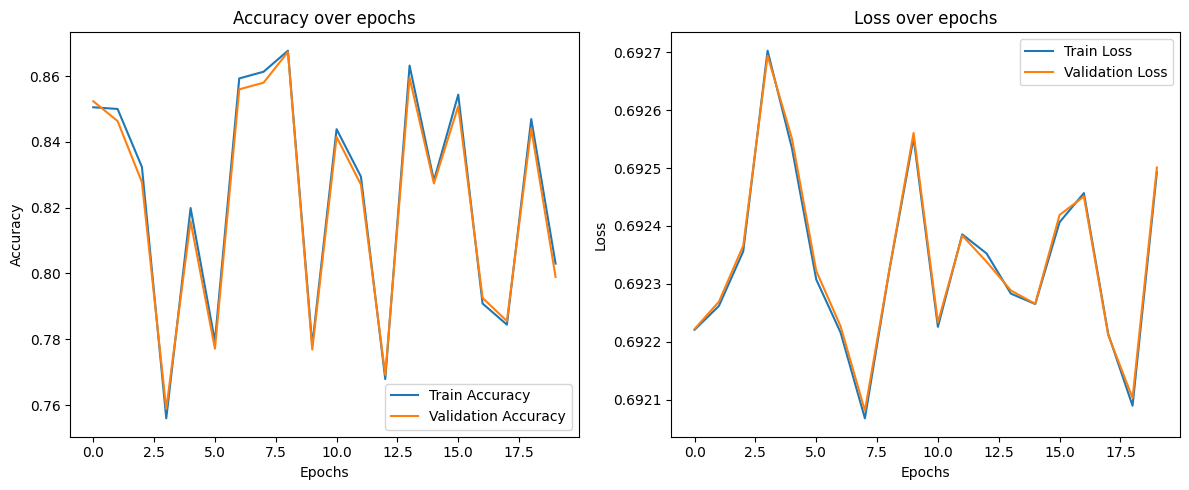

2024-10-10 04:02:51,582 - INFO - Testing Results:
2024-10-10 04:02:51,584 - INFO - Test Loss: 0.6925, Test Accuracy: 0.8079, 
2024-10-10 04:02:51,586 - INFO - Test ROC AUC: 0.8539, Precision: 0.7833, 
2024-10-10 04:02:51,588 - INFO - Recall: 0.6673, F1: 0.7206
2024-10-10 04:02:51,590 - INFO - Training an XGBoost model for 20 epochs...


Plot saved to: /kaggle/working/LogisticRegressionAnalysis.png
Testing Logistic Regression Model
Test Loss: 0.6925, Test Accuracy: 0.8079, Test ROC AUC: 0.8539, Precision: 0.7833, Recall: 0.6673, F1: 0.7206
Model not found. Training a new model...


Epochs:   0%|          | 0/20 [00:00<?, ?epoch/s]2024-10-10 04:02:51,596 - INFO - Epoch 1/20 - Shuffling and batching data
2024-10-10 04:04:30,311 - INFO - Train Loss: 0.5912, Train Accuracy: 0.7030, 
2024-10-10 04:04:30,312 - INFO - Train ROC AUC: 0.8115, Precision: 0.8563, 
2024-10-10 04:04:30,313 - INFO - Recall: 0.2448, F1: 0.3808
Epochs:   5%|▌         | 1/20 [01:38<31:15, 98.72s/epoch]2024-10-10 04:04:30,315 - INFO - Epoch 2/20 - Shuffling and batching data


Epoch 1/20
Train Loss: 0.5912, Train Accuracy: 0.7030, Train ROC AUC: 0.8115, Precision: 0.8563, Recall: 0.2448, F1: 0.3808
Val Loss: 0.5904, Val Accuracy: 0.7052, Val ROC AUC: 0.8088, Precision: 0.8479, Recall: 0.2519, F1: 0.3884


2024-10-10 04:06:09,093 - INFO - Train Loss: 0.5474, Train Accuracy: 0.7318, 
2024-10-10 04:06:09,094 - INFO - Train ROC AUC: 0.8226, Precision: 0.6165, 
2024-10-10 04:06:09,096 - INFO - Recall: 0.7434, F1: 0.6740
Epochs:  10%|█         | 2/20 [03:17<29:37, 98.76s/epoch]2024-10-10 04:06:09,099 - INFO - Epoch 3/20 - Shuffling and batching data


Epoch 2/20
Train Loss: 0.5474, Train Accuracy: 0.7318, Train ROC AUC: 0.8226, Precision: 0.6165, Recall: 0.7434, F1: 0.6740
Val Loss: 0.5499, Val Accuracy: 0.7292, Val ROC AUC: 0.8185, Precision: 0.6126, Recall: 0.7377, F1: 0.6693


2024-10-10 04:07:47,942 - INFO - Train Loss: 0.5932, Train Accuracy: 0.6948, 
2024-10-10 04:07:47,944 - INFO - Train ROC AUC: 0.7658, Precision: 0.5787, 
2024-10-10 04:07:47,945 - INFO - Recall: 0.6687, F1: 0.6204
Epochs:  15%|█▌        | 3/20 [04:56<27:59, 98.80s/epoch]2024-10-10 04:07:47,947 - INFO - Epoch 4/20 - Shuffling and batching data


Epoch 3/20
Train Loss: 0.5932, Train Accuracy: 0.6948, Train ROC AUC: 0.7658, Precision: 0.5787, Recall: 0.6687, F1: 0.6204
Val Loss: 0.5949, Val Accuracy: 0.6927, Val ROC AUC: 0.7631, Precision: 0.5741, Recall: 0.6705, F1: 0.6186


2024-10-10 04:09:27,408 - INFO - Train Loss: 0.5736, Train Accuracy: 0.7052, 
2024-10-10 04:09:27,410 - INFO - Train ROC AUC: 0.7635, Precision: 0.6263, 
2024-10-10 04:09:27,412 - INFO - Recall: 0.5202, F1: 0.5684
Epochs:  20%|██        | 4/20 [06:35<26:24, 99.06s/epoch]2024-10-10 04:09:27,414 - INFO - Epoch 5/20 - Shuffling and batching data


Epoch 4/20
Train Loss: 0.5736, Train Accuracy: 0.7052, Train ROC AUC: 0.7635, Precision: 0.6263, Recall: 0.5202, F1: 0.5684
Val Loss: 0.5726, Val Accuracy: 0.7070, Val ROC AUC: 0.7638, Precision: 0.6262, Recall: 0.5246, F1: 0.5709


2024-10-10 04:11:06,207 - INFO - Train Loss: 0.5999, Train Accuracy: 0.6835, 
2024-10-10 04:11:06,209 - INFO - Train ROC AUC: 0.7340, Precision: 0.9007, 
2024-10-10 04:11:06,210 - INFO - Recall: 0.1703, F1: 0.2865
Epochs:  25%|██▌       | 5/20 [08:14<24:44, 98.97s/epoch]2024-10-10 04:11:06,212 - INFO - Epoch 6/20 - Shuffling and batching data


Epoch 5/20
Train Loss: 0.5999, Train Accuracy: 0.6835, Train ROC AUC: 0.7340, Precision: 0.9007, Recall: 0.1703, F1: 0.2865
Val Loss: 0.6016, Val Accuracy: 0.6843, Val ROC AUC: 0.7266, Precision: 0.9094, Recall: 0.1670, F1: 0.2821


2024-10-10 04:12:44,888 - INFO - Train Loss: 0.7047, Train Accuracy: 0.6638, 
2024-10-10 04:12:44,889 - INFO - Train ROC AUC: 0.7081, Precision: 0.5360, 
2024-10-10 04:12:44,894 - INFO - Recall: 0.7347, F1: 0.6198
Epochs:  30%|███       | 6/20 [09:53<23:04, 98.87s/epoch]2024-10-10 04:12:44,896 - INFO - Epoch 7/20 - Shuffling and batching data


Epoch 6/20
Train Loss: 0.7047, Train Accuracy: 0.6638, Train ROC AUC: 0.7081, Precision: 0.5360, Recall: 0.7347, F1: 0.6198
Val Loss: 0.7021, Val Accuracy: 0.6666, Val ROC AUC: 0.7112, Precision: 0.5374, Recall: 0.7371, F1: 0.6216


2024-10-10 04:14:23,302 - INFO - Train Loss: 0.5926, Train Accuracy: 0.6695, 
2024-10-10 04:14:23,304 - INFO - Train ROC AUC: 0.7297, Precision: 0.5824, 
2024-10-10 04:14:23,305 - INFO - Recall: 0.4024, F1: 0.4760
Epochs:  35%|███▌      | 7/20 [11:31<21:23, 98.72s/epoch]2024-10-10 04:14:23,310 - INFO - Epoch 8/20 - Shuffling and batching data


Epoch 7/20
Train Loss: 0.5926, Train Accuracy: 0.6695, Train ROC AUC: 0.7297, Precision: 0.5824, Recall: 0.4024, F1: 0.4760
Val Loss: 0.5908, Val Accuracy: 0.6715, Val ROC AUC: 0.7325, Precision: 0.5835, Recall: 0.4051, F1: 0.4782


2024-10-10 04:16:01,989 - INFO - Train Loss: 0.5562, Train Accuracy: 0.7236, 
2024-10-10 04:16:01,990 - INFO - Train ROC AUC: 0.8215, Precision: 0.8728, 
2024-10-10 04:16:01,992 - INFO - Recall: 0.3032, F1: 0.4501
Epochs:  40%|████      | 8/20 [13:10<19:44, 98.71s/epoch]2024-10-10 04:16:01,994 - INFO - Epoch 9/20 - Shuffling and batching data


Epoch 8/20
Train Loss: 0.5562, Train Accuracy: 0.7236, Train ROC AUC: 0.8215, Precision: 0.8728, Recall: 0.3032, F1: 0.4501
Val Loss: 0.5602, Val Accuracy: 0.7239, Val ROC AUC: 0.8155, Precision: 0.8740, Recall: 0.3002, F1: 0.4469


2024-10-10 04:17:39,709 - INFO - Train Loss: 0.5495, Train Accuracy: 0.7315, 
2024-10-10 04:17:39,711 - INFO - Train ROC AUC: 0.7945, Precision: 0.7832, 
2024-10-10 04:17:39,713 - INFO - Recall: 0.3877, F1: 0.5186
Epochs:  45%|████▌     | 9/20 [14:48<18:02, 98.40s/epoch]2024-10-10 04:17:39,715 - INFO - Epoch 10/20 - Shuffling and batching data


Epoch 9/20
Train Loss: 0.5495, Train Accuracy: 0.7315, Train ROC AUC: 0.7945, Precision: 0.7832, Recall: 0.3877, F1: 0.5186
Val Loss: 0.5541, Val Accuracy: 0.7270, Val ROC AUC: 0.7897, Precision: 0.7744, Recall: 0.3744, F1: 0.5047


2024-10-10 04:19:17,423 - INFO - Train Loss: 0.5141, Train Accuracy: 0.8195, 
2024-10-10 04:19:17,425 - INFO - Train ROC AUC: 0.8516, Precision: 0.8169, 
2024-10-10 04:19:17,426 - INFO - Recall: 0.6654, F1: 0.7334
Epochs:  50%|█████     | 10/20 [16:25<16:21, 98.19s/epoch]2024-10-10 04:19:17,428 - INFO - Epoch 11/20 - Shuffling and batching data


Epoch 10/20
Train Loss: 0.5141, Train Accuracy: 0.8195, Train ROC AUC: 0.8516, Precision: 0.8169, Recall: 0.6654, F1: 0.7334
Val Loss: 0.5142, Val Accuracy: 0.8164, Val ROC AUC: 0.8500, Precision: 0.8089, Recall: 0.6624, F1: 0.7284


2024-10-10 04:20:55,155 - INFO - Train Loss: 0.5408, Train Accuracy: 0.7466, 
2024-10-10 04:20:55,157 - INFO - Train ROC AUC: 0.8309, Precision: 0.7801, 
2024-10-10 04:20:55,159 - INFO - Recall: 0.4466, F1: 0.5681
Epochs:  55%|█████▌    | 11/20 [18:03<14:42, 98.05s/epoch]2024-10-10 04:20:55,161 - INFO - Epoch 12/20 - Shuffling and batching data


Epoch 11/20
Train Loss: 0.5408, Train Accuracy: 0.7466, Train ROC AUC: 0.8309, Precision: 0.7801, Recall: 0.4466, F1: 0.5681
Val Loss: 0.5391, Val Accuracy: 0.7468, Val ROC AUC: 0.8331, Precision: 0.7788, Recall: 0.4450, F1: 0.5664


2024-10-10 04:22:33,893 - INFO - Train Loss: 0.5040, Train Accuracy: 0.7692, 
2024-10-10 04:22:33,895 - INFO - Train ROC AUC: 0.8689, Precision: 0.9451, 
2024-10-10 04:22:33,896 - INFO - Recall: 0.4047, F1: 0.5667
Epochs:  60%|██████    | 12/20 [19:42<13:06, 98.26s/epoch]2024-10-10 04:22:33,899 - INFO - Epoch 13/20 - Shuffling and batching data


Epoch 12/20
Train Loss: 0.5040, Train Accuracy: 0.7692, Train ROC AUC: 0.8689, Precision: 0.9451, Recall: 0.4047, F1: 0.5667
Val Loss: 0.5074, Val Accuracy: 0.7653, Val ROC AUC: 0.8640, Precision: 0.9294, Recall: 0.3987, F1: 0.5580


2024-10-10 04:24:12,040 - INFO - Train Loss: 0.5514, Train Accuracy: 0.7355, 
2024-10-10 04:24:12,041 - INFO - Train ROC AUC: 0.8144, Precision: 0.6529, 
2024-10-10 04:24:12,042 - INFO - Recall: 0.6211, F1: 0.6366
Epochs:  65%|██████▌   | 13/20 [21:20<11:27, 98.22s/epoch]2024-10-10 04:24:12,045 - INFO - Epoch 14/20 - Shuffling and batching data


Epoch 13/20
Train Loss: 0.5514, Train Accuracy: 0.7355, Train ROC AUC: 0.8144, Precision: 0.6529, Recall: 0.6211, F1: 0.6366
Val Loss: 0.5538, Val Accuracy: 0.7331, Val ROC AUC: 0.8118, Precision: 0.6456, Recall: 0.6248, F1: 0.6350


2024-10-10 04:25:49,411 - INFO - Train Loss: 0.5208, Train Accuracy: 0.7932, 
2024-10-10 04:25:49,412 - INFO - Train ROC AUC: 0.8397, Precision: 0.8809, 
2024-10-10 04:25:49,413 - INFO - Recall: 0.5151, F1: 0.6501
Epochs:  70%|███████   | 14/20 [22:57<09:47, 97.97s/epoch]2024-10-10 04:25:49,415 - INFO - Epoch 15/20 - Shuffling and batching data


Epoch 14/20
Train Loss: 0.5208, Train Accuracy: 0.7932, Train ROC AUC: 0.8397, Precision: 0.8809, Recall: 0.5151, F1: 0.6501
Val Loss: 0.5201, Val Accuracy: 0.7965, Val ROC AUC: 0.8388, Precision: 0.8809, Recall: 0.5232, F1: 0.6565


2024-10-10 04:27:27,636 - INFO - Train Loss: 0.5822, Train Accuracy: 0.7341, 
2024-10-10 04:27:27,638 - INFO - Train ROC AUC: 0.7676, Precision: 0.7828, 
2024-10-10 04:27:27,638 - INFO - Recall: 0.3976, F1: 0.5274
Epochs:  75%|███████▌  | 15/20 [24:36<08:10, 98.04s/epoch]2024-10-10 04:27:27,641 - INFO - Epoch 16/20 - Shuffling and batching data


Epoch 15/20
Train Loss: 0.5822, Train Accuracy: 0.7341, Train ROC AUC: 0.7676, Precision: 0.7828, Recall: 0.3976, F1: 0.5274
Val Loss: 0.5830, Val Accuracy: 0.7336, Val ROC AUC: 0.7681, Precision: 0.7878, Recall: 0.3874, F1: 0.5194


2024-10-10 04:29:06,473 - INFO - Train Loss: 0.5620, Train Accuracy: 0.7494, 
2024-10-10 04:29:06,474 - INFO - Train ROC AUC: 0.8159, Precision: 0.6391, 
2024-10-10 04:29:06,475 - INFO - Recall: 0.7543, F1: 0.6919
Epochs:  80%|████████  | 16/20 [26:14<06:33, 98.28s/epoch]2024-10-10 04:29:06,477 - INFO - Epoch 17/20 - Shuffling and batching data


Epoch 16/20
Train Loss: 0.5620, Train Accuracy: 0.7494, Train ROC AUC: 0.8159, Precision: 0.6391, Recall: 0.7543, F1: 0.6919
Val Loss: 0.5652, Val Accuracy: 0.7437, Val ROC AUC: 0.8097, Precision: 0.6307, Recall: 0.7485, F1: 0.6846


2024-10-10 04:30:44,637 - INFO - Train Loss: 0.5968, Train Accuracy: 0.6815, 
2024-10-10 04:30:44,638 - INFO - Train ROC AUC: 0.7477, Precision: 0.8123, 
2024-10-10 04:30:44,640 - INFO - Recall: 0.1902, F1: 0.3082
Epochs:  85%|████████▌ | 17/20 [27:53<04:54, 98.25s/epoch]2024-10-10 04:30:44,642 - INFO - Epoch 18/20 - Shuffling and batching data


Epoch 17/20
Train Loss: 0.5968, Train Accuracy: 0.6815, Train ROC AUC: 0.7477, Precision: 0.8123, Recall: 0.1902, F1: 0.3082
Val Loss: 0.5981, Val Accuracy: 0.6824, Val ROC AUC: 0.7425, Precision: 0.8150, Recall: 0.1878, F1: 0.3053


2024-10-10 04:32:22,243 - INFO - Train Loss: 0.5392, Train Accuracy: 0.7503, 
2024-10-10 04:32:22,245 - INFO - Train ROC AUC: 0.8249, Precision: 0.8866, 
2024-10-10 04:32:22,246 - INFO - Recall: 0.3792, F1: 0.5312
Epochs:  90%|█████████ | 18/20 [29:30<03:16, 98.05s/epoch]2024-10-10 04:32:22,249 - INFO - Epoch 19/20 - Shuffling and batching data


Epoch 18/20
Train Loss: 0.5392, Train Accuracy: 0.7503, Train ROC AUC: 0.8249, Precision: 0.8866, Recall: 0.3792, F1: 0.5312
Val Loss: 0.5369, Val Accuracy: 0.7524, Val ROC AUC: 0.8279, Precision: 0.8836, Recall: 0.3843, F1: 0.5356


2024-10-10 04:33:59,492 - INFO - Train Loss: 0.5763, Train Accuracy: 0.7166, 
2024-10-10 04:33:59,493 - INFO - Train ROC AUC: 0.7774, Precision: 0.6020, 
2024-10-10 04:33:59,494 - INFO - Recall: 0.7088, F1: 0.6511
Epochs:  95%|█████████▌| 19/20 [31:07<01:37, 97.81s/epoch]2024-10-10 04:33:59,496 - INFO - Epoch 20/20 - Shuffling and batching data


Epoch 19/20
Train Loss: 0.5763, Train Accuracy: 0.7166, Train ROC AUC: 0.7774, Precision: 0.6020, Recall: 0.7088, F1: 0.6511
Val Loss: 0.5792, Val Accuracy: 0.7130, Val ROC AUC: 0.7736, Precision: 0.5957, Recall: 0.7080, F1: 0.6470


2024-10-10 04:35:36,404 - INFO - Train Loss: 0.5456, Train Accuracy: 0.7080, 
2024-10-10 04:35:36,407 - INFO - Train ROC AUC: 0.8153, Precision: 0.7332, 
2024-10-10 04:35:36,413 - INFO - Recall: 0.3417, F1: 0.4661
Epochs: 100%|██████████| 20/20 [32:44<00:00, 98.24s/epoch]


Epoch 20/20
Train Loss: 0.5456, Train Accuracy: 0.7080, Train ROC AUC: 0.8153, Precision: 0.7332, Recall: 0.3417, F1: 0.4661
Val Loss: 0.5492, Val Accuracy: 0.7040, Val ROC AUC: 0.8079, Precision: 0.7151, Recall: 0.3382, F1: 0.4593
Model saved to /kaggle/working/xgboost_model.pkl


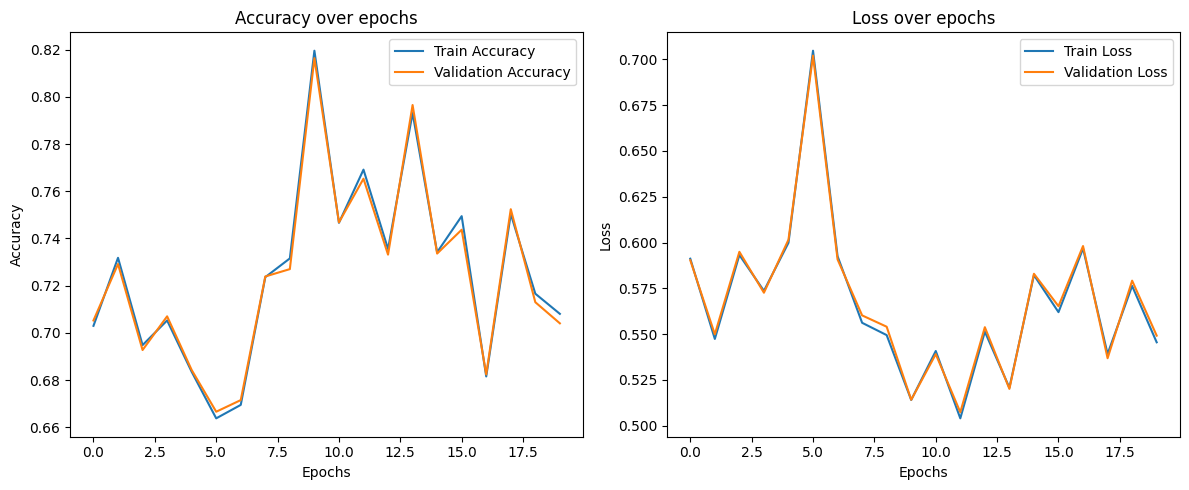

2024-10-10 04:35:37,678 - INFO - Testing Results:
2024-10-10 04:35:37,680 - INFO - Test Loss: 0.5423, Test Accuracy: 0.7132, 
2024-10-10 04:35:37,681 - INFO - Test ROC AUC: 0.8191, Precision: 0.7527, 
2024-10-10 04:35:37,683 - INFO - Recall: 0.3393, F1: 0.4678
2024-10-10 04:35:37,684 - INFO - Training a Random Forest model for 20 epochs...


Plot saved to: /kaggle/working/xgboost_training_validation_curves.jpg
Testing XGBoost Model
Test Loss: 0.5423, Test Accuracy: 0.7132, Test ROC AUC: 0.8191, Precision: 0.7527, Recall: 0.3393, F1: 0.4678
Model not found. Training a new model...


Epochs:   0%|          | 0/20 [00:00<?, ?epoch/s]2024-10-10 04:35:37,687 - INFO - Epoch 1/20 - Shuffling and batching data
2024-10-10 04:36:51,334 - INFO - Train Loss: 0.4946, Train Accuracy: 0.7884, 
2024-10-10 04:36:51,335 - INFO - Train ROC AUC: 0.8532, Precision: 0.7967, 
2024-10-10 04:36:51,336 - INFO - Recall: 0.5811, F1: 0.6720
Epochs:   5%|▌         | 1/20 [01:13<23:19, 73.65s/epoch]2024-10-10 04:36:51,339 - INFO - Epoch 2/20 - Shuffling and batching data


Epoch 1/20
Train Loss: 0.4946, Train Accuracy: 0.7884, Train ROC AUC: 0.8532, Precision: 0.7967, Recall: 0.5811, F1: 0.6720
Val Loss: 0.4959, Val Accuracy: 0.7836, Val ROC AUC: 0.8506, Precision: 0.7814, Recall: 0.5798, F1: 0.6656


2024-10-10 04:38:04,885 - INFO - Train Loss: 0.4901, Train Accuracy: 0.8409, 
2024-10-10 04:38:04,886 - INFO - Train ROC AUC: 0.8877, Precision: 0.8009, 
2024-10-10 04:38:04,887 - INFO - Recall: 0.7633, F1: 0.7817
Epochs:  10%|█         | 2/20 [02:27<22:04, 73.59s/epoch]2024-10-10 04:38:04,889 - INFO - Epoch 3/20 - Shuffling and batching data


Epoch 2/20
Train Loss: 0.4901, Train Accuracy: 0.8409, Train ROC AUC: 0.8877, Precision: 0.8009, Recall: 0.7633, F1: 0.7817
Val Loss: 0.5190, Val Accuracy: 0.8401, Val ROC AUC: 0.8837, Precision: 0.7988, Recall: 0.7613, F1: 0.7796


2024-10-10 04:39:19,651 - INFO - Train Loss: 0.4793, Train Accuracy: 0.8226, 
2024-10-10 04:39:19,652 - INFO - Train ROC AUC: 0.8906, Precision: 0.8759, 
2024-10-10 04:39:19,653 - INFO - Recall: 0.6112, F1: 0.7200
Epochs:  15%|█▌        | 3/20 [03:41<21:00, 74.13s/epoch]2024-10-10 04:39:19,655 - INFO - Epoch 4/20 - Shuffling and batching data


Epoch 3/20
Train Loss: 0.4793, Train Accuracy: 0.8226, Train ROC AUC: 0.8906, Precision: 0.8759, Recall: 0.6112, F1: 0.7200
Val Loss: 0.4755, Val Accuracy: 0.8229, Val ROC AUC: 0.8944, Precision: 0.8692, Recall: 0.6162, F1: 0.7211


2024-10-10 04:40:34,527 - INFO - Train Loss: 0.4914, Train Accuracy: 0.7968, 
2024-10-10 04:40:34,528 - INFO - Train ROC AUC: 0.8561, Precision: 0.7403, 
2024-10-10 04:40:34,530 - INFO - Recall: 0.7013, F1: 0.7203
Epochs:  20%|██        | 4/20 [04:56<19:50, 74.42s/epoch]2024-10-10 04:40:34,533 - INFO - Epoch 5/20 - Shuffling and batching data


Epoch 4/20
Train Loss: 0.4914, Train Accuracy: 0.7968, Train ROC AUC: 0.8561, Precision: 0.7403, Recall: 0.7013, F1: 0.7203
Val Loss: 0.4999, Val Accuracy: 0.7902, Val ROC AUC: 0.8471, Precision: 0.7277, Recall: 0.6958, F1: 0.7114


2024-10-10 04:41:49,543 - INFO - Train Loss: 0.5044, Train Accuracy: 0.7890, 
2024-10-10 04:41:49,544 - INFO - Train ROC AUC: 0.8461, Precision: 0.7428, 
2024-10-10 04:41:49,546 - INFO - Recall: 0.6645, F1: 0.7015
Epochs:  25%|██▌       | 5/20 [06:11<18:39, 74.64s/epoch]2024-10-10 04:41:49,548 - INFO - Epoch 6/20 - Shuffling and batching data


Epoch 5/20
Train Loss: 0.5044, Train Accuracy: 0.7890, Train ROC AUC: 0.8461, Precision: 0.7428, Recall: 0.6645, F1: 0.7015
Val Loss: 0.5059, Val Accuracy: 0.7864, Val ROC AUC: 0.8427, Precision: 0.7371, Recall: 0.6608, F1: 0.6969


2024-10-10 04:43:03,104 - INFO - Train Loss: 0.5124, Train Accuracy: 0.7436, 
2024-10-10 04:43:03,106 - INFO - Train ROC AUC: 0.8993, Precision: 0.9752, 
2024-10-10 04:43:03,107 - INFO - Recall: 0.3210, F1: 0.4830
Epochs:  30%|███       | 6/20 [07:25<17:19, 74.27s/epoch]2024-10-10 04:43:03,110 - INFO - Epoch 7/20 - Shuffling and batching data


Epoch 6/20
Train Loss: 0.5124, Train Accuracy: 0.7436, Train ROC AUC: 0.8993, Precision: 0.9752, Recall: 0.3210, F1: 0.4830
Val Loss: 0.5003, Val Accuracy: 0.7437, Val ROC AUC: 0.8976, Precision: 0.9693, Recall: 0.3204, F1: 0.4816


2024-10-10 04:44:17,583 - INFO - Train Loss: 0.6825, Train Accuracy: 0.7826, 
2024-10-10 04:44:17,584 - INFO - Train ROC AUC: 0.8472, Precision: 0.8508, 
2024-10-10 04:44:17,585 - INFO - Recall: 0.5058, F1: 0.6345
Epochs:  35%|███▌      | 7/20 [08:39<16:06, 74.34s/epoch]2024-10-10 04:44:17,587 - INFO - Epoch 8/20 - Shuffling and batching data


Epoch 7/20
Train Loss: 0.6825, Train Accuracy: 0.7826, Train ROC AUC: 0.8472, Precision: 0.8508, Recall: 0.5058, F1: 0.6345
Val Loss: 0.6816, Val Accuracy: 0.7782, Val ROC AUC: 0.8421, Precision: 0.8365, Recall: 0.5010, F1: 0.6267


2024-10-10 04:45:32,948 - INFO - Train Loss: 0.4419, Train Accuracy: 0.8292, 
2024-10-10 04:45:32,950 - INFO - Train ROC AUC: 0.8937, Precision: 0.8907, 
2024-10-10 04:45:32,951 - INFO - Recall: 0.6178, F1: 0.7296
Epochs:  40%|████      | 8/20 [09:55<14:55, 74.67s/epoch]2024-10-10 04:45:32,953 - INFO - Epoch 9/20 - Shuffling and batching data


Epoch 8/20
Train Loss: 0.4419, Train Accuracy: 0.8292, Train ROC AUC: 0.8937, Precision: 0.8907, Recall: 0.6178, F1: 0.7296
Val Loss: 0.4427, Val Accuracy: 0.8269, Val ROC AUC: 0.8917, Precision: 0.8850, Recall: 0.6141, F1: 0.7251


2024-10-10 04:46:48,572 - INFO - Train Loss: 0.4947, Train Accuracy: 0.8302, 
2024-10-10 04:46:48,573 - INFO - Train ROC AUC: 0.8939, Precision: 0.9112, 
2024-10-10 04:46:48,574 - INFO - Recall: 0.6037, F1: 0.7262
Epochs:  45%|████▌     | 9/20 [11:10<13:44, 74.97s/epoch]2024-10-10 04:46:48,576 - INFO - Epoch 10/20 - Shuffling and batching data


Epoch 9/20
Train Loss: 0.4947, Train Accuracy: 0.8302, Train ROC AUC: 0.8939, Precision: 0.9112, Recall: 0.6037, F1: 0.7262
Val Loss: 0.5069, Val Accuracy: 0.8295, Val ROC AUC: 0.8902, Precision: 0.9071, Recall: 0.6028, F1: 0.7243


2024-10-10 04:48:05,234 - INFO - Train Loss: 0.4702, Train Accuracy: 0.8126, 
2024-10-10 04:48:05,235 - INFO - Train ROC AUC: 0.8777, Precision: 0.8566, 
2024-10-10 04:48:05,236 - INFO - Recall: 0.5978, F1: 0.7041
Epochs:  50%|█████     | 10/20 [12:27<12:34, 75.49s/epoch]2024-10-10 04:48:05,238 - INFO - Epoch 11/20 - Shuffling and batching data


Epoch 10/20
Train Loss: 0.4702, Train Accuracy: 0.8126, Train ROC AUC: 0.8777, Precision: 0.8566, Recall: 0.5978, F1: 0.7041
Val Loss: 0.4681, Val Accuracy: 0.8127, Val ROC AUC: 0.8757, Precision: 0.8489, Recall: 0.6034, F1: 0.7054


2024-10-10 04:49:21,459 - INFO - Train Loss: 0.5505, Train Accuracy: 0.7053, 
2024-10-10 04:49:21,460 - INFO - Train ROC AUC: 0.8567, Precision: 0.5675, 
2024-10-10 04:49:21,461 - INFO - Recall: 0.8834, F1: 0.6910
Epochs:  55%|█████▌    | 11/20 [13:43<11:21, 75.71s/epoch]2024-10-10 04:49:21,464 - INFO - Epoch 12/20 - Shuffling and batching data


Epoch 11/20
Train Loss: 0.5505, Train Accuracy: 0.7053, Train ROC AUC: 0.8567, Precision: 0.5675, Recall: 0.8834, F1: 0.6910
Val Loss: 0.5693, Val Accuracy: 0.6938, Val ROC AUC: 0.8500, Precision: 0.5555, Recall: 0.8805, F1: 0.6812


2024-10-10 04:50:37,448 - INFO - Train Loss: 0.4634, Train Accuracy: 0.8055, 
2024-10-10 04:50:37,449 - INFO - Train ROC AUC: 0.9099, Precision: 0.9451, 
2024-10-10 04:50:37,451 - INFO - Recall: 0.5082, F1: 0.6610
Epochs:  60%|██████    | 12/20 [14:59<10:06, 75.80s/epoch]2024-10-10 04:50:37,454 - INFO - Epoch 13/20 - Shuffling and batching data


Epoch 12/20
Train Loss: 0.4634, Train Accuracy: 0.8055, Train ROC AUC: 0.9099, Precision: 0.9451, Recall: 0.5082, F1: 0.6610
Val Loss: 0.4688, Val Accuracy: 0.8037, Val ROC AUC: 0.9086, Precision: 0.9380, Recall: 0.5052, F1: 0.6567


2024-10-10 04:51:53,514 - INFO - Train Loss: 0.5854, Train Accuracy: 0.7665, 
2024-10-10 04:51:53,515 - INFO - Train ROC AUC: 0.8629, Precision: 0.9656, 
2024-10-10 04:51:53,516 - INFO - Recall: 0.3879, F1: 0.5535
Epochs:  65%|██████▌   | 13/20 [16:15<08:51, 75.88s/epoch]2024-10-10 04:51:53,518 - INFO - Epoch 14/20 - Shuffling and batching data


Epoch 13/20
Train Loss: 0.5854, Train Accuracy: 0.7665, Train ROC AUC: 0.8629, Precision: 0.9656, Recall: 0.3879, F1: 0.5535
Val Loss: 0.5969, Val Accuracy: 0.7669, Val ROC AUC: 0.8641, Precision: 0.9593, Recall: 0.3893, F1: 0.5538


2024-10-10 04:53:08,859 - INFO - Train Loss: 0.4675, Train Accuracy: 0.7976, 
2024-10-10 04:53:08,860 - INFO - Train ROC AUC: 0.8782, Precision: 0.8412, 
2024-10-10 04:53:08,861 - INFO - Recall: 0.5637, F1: 0.6751
Epochs:  70%|███████   | 14/20 [17:31<07:34, 75.72s/epoch]2024-10-10 04:53:08,864 - INFO - Epoch 15/20 - Shuffling and batching data


Epoch 14/20
Train Loss: 0.4675, Train Accuracy: 0.7976, Train ROC AUC: 0.8782, Precision: 0.8412, Recall: 0.5637, F1: 0.6751
Val Loss: 0.4621, Val Accuracy: 0.7970, Val ROC AUC: 0.8775, Precision: 0.8373, Recall: 0.5633, F1: 0.6735


2024-10-10 04:54:24,352 - INFO - Train Loss: 0.5389, Train Accuracy: 0.7897, 
2024-10-10 04:54:24,354 - INFO - Train ROC AUC: 0.8613, Precision: 0.8490, 
2024-10-10 04:54:24,355 - INFO - Recall: 0.5307, F1: 0.6532
Epochs:  75%|███████▌  | 15/20 [18:46<06:18, 75.65s/epoch]2024-10-10 04:54:24,357 - INFO - Epoch 16/20 - Shuffling and batching data


Epoch 15/20
Train Loss: 0.5389, Train Accuracy: 0.7897, Train ROC AUC: 0.8613, Precision: 0.8490, Recall: 0.5307, F1: 0.6532
Val Loss: 0.5377, Val Accuracy: 0.7906, Val ROC AUC: 0.8594, Precision: 0.8447, Recall: 0.5350, F1: 0.6551


2024-10-10 04:55:39,438 - INFO - Train Loss: 0.5096, Train Accuracy: 0.7732, 
2024-10-10 04:55:39,439 - INFO - Train ROC AUC: 0.8752, Precision: 0.9396, 
2024-10-10 04:55:39,440 - INFO - Recall: 0.4191, F1: 0.5796
Epochs:  80%|████████  | 16/20 [20:01<05:01, 75.48s/epoch]2024-10-10 04:55:39,442 - INFO - Epoch 17/20 - Shuffling and batching data


Epoch 16/20
Train Loss: 0.5096, Train Accuracy: 0.7732, Train ROC AUC: 0.8752, Precision: 0.9396, Recall: 0.4191, F1: 0.5796
Val Loss: 0.5053, Val Accuracy: 0.7773, Val ROC AUC: 0.8750, Precision: 0.9421, Recall: 0.4270, F1: 0.5877


2024-10-10 04:56:55,246 - INFO - Train Loss: 0.4411, Train Accuracy: 0.8387, 
2024-10-10 04:56:55,247 - INFO - Train ROC AUC: 0.8904, Precision: 0.7760, 
2024-10-10 04:56:55,248 - INFO - Recall: 0.7981, F1: 0.7869
Epochs:  85%|████████▌ | 17/20 [21:17<03:46, 75.58s/epoch]2024-10-10 04:56:55,250 - INFO - Epoch 18/20 - Shuffling and batching data


Epoch 17/20
Train Loss: 0.4411, Train Accuracy: 0.8387, Train ROC AUC: 0.8904, Precision: 0.7760, Recall: 0.7981, F1: 0.7869
Val Loss: 0.4474, Val Accuracy: 0.8329, Val ROC AUC: 0.8872, Precision: 0.7650, Recall: 0.7945, F1: 0.7795


2024-10-10 04:58:10,807 - INFO - Train Loss: 0.5487, Train Accuracy: 0.7736, 
2024-10-10 04:58:10,808 - INFO - Train ROC AUC: 0.8348, Precision: 0.8581, 
2024-10-10 04:58:10,809 - INFO - Recall: 0.4709, F1: 0.6081
Epochs:  90%|█████████ | 18/20 [22:33<02:31, 75.57s/epoch]2024-10-10 04:58:10,812 - INFO - Epoch 19/20 - Shuffling and batching data


Epoch 18/20
Train Loss: 0.5487, Train Accuracy: 0.7736, Train ROC AUC: 0.8348, Precision: 0.8581, Recall: 0.4709, F1: 0.6081
Val Loss: 0.5596, Val Accuracy: 0.7722, Val ROC AUC: 0.8300, Precision: 0.8479, Recall: 0.4715, F1: 0.6060


2024-10-10 04:59:26,690 - INFO - Train Loss: 0.4882, Train Accuracy: 0.7780, 
2024-10-10 04:59:26,691 - INFO - Train ROC AUC: 0.8645, Precision: 0.8140, 
2024-10-10 04:59:26,692 - INFO - Recall: 0.5247, F1: 0.6381
Epochs:  95%|█████████▌| 19/20 [23:49<01:15, 75.67s/epoch]2024-10-10 04:59:26,694 - INFO - Epoch 20/20 - Shuffling and batching data


Epoch 19/20
Train Loss: 0.4882, Train Accuracy: 0.7780, Train ROC AUC: 0.8645, Precision: 0.8140, Recall: 0.5247, F1: 0.6381
Val Loss: 0.4953, Val Accuracy: 0.7749, Val ROC AUC: 0.8582, Precision: 0.8049, Recall: 0.5204, F1: 0.6321


2024-10-10 05:00:42,613 - INFO - Train Loss: 0.4786, Train Accuracy: 0.7928, 
2024-10-10 05:00:42,614 - INFO - Train ROC AUC: 0.8839, Precision: 0.9138, 
2024-10-10 05:00:42,615 - INFO - Recall: 0.4910, F1: 0.6387
Epochs: 100%|██████████| 20/20 [25:04<00:00, 75.25s/epoch]


Epoch 20/20
Train Loss: 0.4786, Train Accuracy: 0.7928, Train ROC AUC: 0.8839, Precision: 0.9138, Recall: 0.4910, F1: 0.6387
Val Loss: 0.4833, Val Accuracy: 0.7897, Val ROC AUC: 0.8772, Precision: 0.9034, Recall: 0.4860, F1: 0.6320
Model saved to /kaggle/working/randomforest_model.pkl


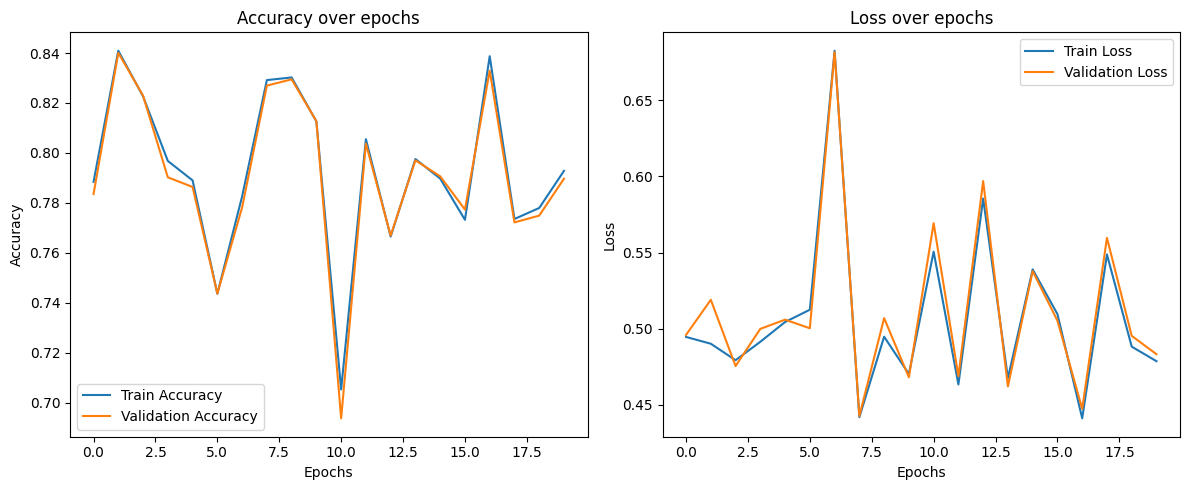

2024-10-10 05:00:43,836 - INFO - Testing Results:
2024-10-10 05:00:43,838 - INFO - Test Loss: 0.4816, Test Accuracy: 0.7933, 
2024-10-10 05:00:43,838 - INFO - Test ROC AUC: 0.8823, Precision: 0.9069, 
2024-10-10 05:00:43,840 - INFO - Recall: 0.4941, F1: 0.6397
2024-10-10 05:00:43,841 - INFO - Training a LinearSVC model for 20 epochs...


Plot saved to: /kaggle/working/RF_training_validation_curves.jpg
Testing Random Forest Model
Test Loss: 0.4816, Test Accuracy: 0.7933, Test ROC AUC: 0.8823, Precision: 0.9069, Recall: 0.4941, F1: 0.6397
Model not found. Training a new model...


Epochs:   0%|          | 0/20 [00:00<?, ?epoch/s]2024-10-10 05:00:43,845 - INFO - Epoch 1/20 - Shuffling and batching data
2024-10-10 05:00:48,354 - INFO - Train Loss: 3.1046, Train Accuracy: 0.7054, 
2024-10-10 05:00:48,355 - INFO - Train ROC AUC: 0.9191, Precision: 0.9962, 
2024-10-10 05:00:48,356 - INFO - Recall: 0.2112, F1: 0.3485
Epochs:   5%|▌         | 1/20 [00:04<01:25,  4.51s/epoch]2024-10-10 05:00:48,358 - INFO - Epoch 2/20 - Shuffling and batching data


Epoch 1/20
Train Loss: 3.1046, Train Accuracy: 0.7054, Train ROC AUC: 0.9191, Precision: 0.9962, Recall: 0.2112, F1: 0.3485
Val Loss: 3.0964, Val Accuracy: 0.7088, Val ROC AUC: 0.9173, Precision: 0.9920, Recall: 0.2182, F1: 0.3578


2024-10-10 05:00:52,839 - INFO - Train Loss: 3.4788, Train Accuracy: 0.7146, 
2024-10-10 05:00:52,840 - INFO - Train ROC AUC: 0.9109, Precision: 0.9972, 
2024-10-10 05:00:52,841 - INFO - Recall: 0.2355, F1: 0.3811
Epochs:  10%|█         | 2/20 [00:08<01:20,  4.50s/epoch]2024-10-10 05:00:52,843 - INFO - Epoch 3/20 - Shuffling and batching data


Epoch 2/20
Train Loss: 3.4788, Train Accuracy: 0.7146, Train ROC AUC: 0.9109, Precision: 0.9972, Recall: 0.2355, F1: 0.3811
Val Loss: 3.4533, Val Accuracy: 0.7181, Val ROC AUC: 0.9074, Precision: 0.9950, Recall: 0.2427, F1: 0.3903


2024-10-10 05:00:57,358 - INFO - Train Loss: 3.1262, Train Accuracy: 0.7425, 
2024-10-10 05:00:57,359 - INFO - Train ROC AUC: 0.9052, Precision: 0.9869, 
2024-10-10 05:00:57,360 - INFO - Recall: 0.3139, F1: 0.4763
Epochs:  15%|█▌        | 3/20 [00:13<01:16,  4.51s/epoch]2024-10-10 05:00:57,362 - INFO - Epoch 4/20 - Shuffling and batching data


Epoch 3/20
Train Loss: 3.1262, Train Accuracy: 0.7425, Train ROC AUC: 0.9052, Precision: 0.9869, Recall: 0.3139, F1: 0.4763
Val Loss: 3.1381, Val Accuracy: 0.7476, Val ROC AUC: 0.9015, Precision: 0.9837, Recall: 0.3262, F1: 0.4899


2024-10-10 05:01:01,900 - INFO - Train Loss: 4.2278, Train Accuracy: 0.6780, 
2024-10-10 05:01:01,902 - INFO - Train ROC AUC: 0.9001, Precision: 0.9933, 
2024-10-10 05:01:01,903 - INFO - Recall: 0.1379, F1: 0.2421
Epochs:  20%|██        | 4/20 [00:18<01:12,  4.52s/epoch]2024-10-10 05:01:01,905 - INFO - Epoch 5/20 - Shuffling and batching data


Epoch 4/20
Train Loss: 4.2278, Train Accuracy: 0.6780, Train ROC AUC: 0.9001, Precision: 0.9933, Recall: 0.1379, F1: 0.2421
Val Loss: 4.1143, Val Accuracy: 0.6821, Val ROC AUC: 0.8996, Precision: 0.9926, Recall: 0.1454, F1: 0.2537


2024-10-10 05:01:06,399 - INFO - Train Loss: 3.8242, Train Accuracy: 0.7024, 
2024-10-10 05:01:06,401 - INFO - Train ROC AUC: 0.9090, Precision: 0.9958, 
2024-10-10 05:01:06,411 - INFO - Recall: 0.2030, F1: 0.3372
Epochs:  25%|██▌       | 5/20 [00:22<01:07,  4.52s/epoch]2024-10-10 05:01:06,413 - INFO - Epoch 6/20 - Shuffling and batching data


Epoch 5/20
Train Loss: 3.8242, Train Accuracy: 0.7024, Train ROC AUC: 0.9090, Precision: 0.9958, Recall: 0.2030, F1: 0.3372
Val Loss: 3.7955, Val Accuracy: 0.7062, Val ROC AUC: 0.9052, Precision: 0.9936, Recall: 0.2107, F1: 0.3476


2024-10-10 05:01:10,991 - INFO - Train Loss: 4.0748, Train Accuracy: 0.6775, 
2024-10-10 05:01:10,993 - INFO - Train ROC AUC: 0.8978, Precision: 0.9976, 
2024-10-10 05:01:10,994 - INFO - Recall: 0.1359, F1: 0.2392
Epochs:  30%|███       | 6/20 [00:27<01:03,  4.54s/epoch]2024-10-10 05:01:10,995 - INFO - Epoch 7/20 - Shuffling and batching data


Epoch 6/20
Train Loss: 4.0748, Train Accuracy: 0.6775, Train ROC AUC: 0.8978, Precision: 0.9976, Recall: 0.1359, F1: 0.2392
Val Loss: 3.9287, Val Accuracy: 0.6791, Val ROC AUC: 0.8997, Precision: 0.9941, Recall: 0.1372, F1: 0.2411


2024-10-10 05:01:15,478 - INFO - Train Loss: 2.7501, Train Accuracy: 0.7234, 
2024-10-10 05:01:15,480 - INFO - Train ROC AUC: 0.9179, Precision: 0.9985, 
2024-10-10 05:01:15,481 - INFO - Recall: 0.2589, F1: 0.4112
Epochs:  35%|███▌      | 7/20 [00:31<00:58,  4.52s/epoch]2024-10-10 05:01:15,483 - INFO - Epoch 8/20 - Shuffling and batching data


Epoch 7/20
Train Loss: 2.7501, Train Accuracy: 0.7234, Train ROC AUC: 0.9179, Precision: 0.9985, Recall: 0.2589, F1: 0.4112
Val Loss: 2.7225, Val Accuracy: 0.7262, Val ROC AUC: 0.9130, Precision: 0.9969, Recall: 0.2640, F1: 0.4174


2024-10-10 05:01:20,016 - INFO - Train Loss: 3.1452, Train Accuracy: 0.7028, 
2024-10-10 05:01:20,017 - INFO - Train ROC AUC: 0.9178, Precision: 0.9990, 
2024-10-10 05:01:20,018 - INFO - Recall: 0.2034, F1: 0.3380
Epochs:  40%|████      | 8/20 [00:36<00:54,  4.53s/epoch]2024-10-10 05:01:20,020 - INFO - Epoch 9/20 - Shuffling and batching data


Epoch 8/20
Train Loss: 3.1452, Train Accuracy: 0.7028, Train ROC AUC: 0.9178, Precision: 0.9990, Recall: 0.2034, F1: 0.3380
Val Loss: 3.1500, Val Accuracy: 0.7069, Val ROC AUC: 0.9128, Precision: 0.9981, Recall: 0.2116, F1: 0.3492


2024-10-10 05:01:24,509 - INFO - Train Loss: 3.3283, Train Accuracy: 0.7195, 
2024-10-10 05:01:24,510 - INFO - Train ROC AUC: 0.9022, Precision: 0.9905, 
2024-10-10 05:01:24,511 - INFO - Recall: 0.2505, F1: 0.3998
Epochs:  45%|████▌     | 9/20 [00:40<00:49,  4.52s/epoch]2024-10-10 05:01:24,514 - INFO - Epoch 10/20 - Shuffling and batching data


Epoch 9/20
Train Loss: 3.3283, Train Accuracy: 0.7195, Train ROC AUC: 0.9022, Precision: 0.9905, Recall: 0.2505, F1: 0.3998
Val Loss: 3.2412, Val Accuracy: 0.7195, Val ROC AUC: 0.9029, Precision: 0.9860, Recall: 0.2485, F1: 0.3970


2024-10-10 05:01:29,029 - INFO - Train Loss: 4.2109, Train Accuracy: 0.6441, 
2024-10-10 05:01:29,031 - INFO - Train ROC AUC: 0.8647, Precision: 0.9929, 
2024-10-10 05:01:29,032 - INFO - Recall: 0.0464, F1: 0.0887
Epochs:  50%|█████     | 10/20 [00:45<00:45,  4.52s/epoch]2024-10-10 05:01:29,034 - INFO - Epoch 11/20 - Shuffling and batching data


Epoch 10/20
Train Loss: 4.2109, Train Accuracy: 0.6441, Train ROC AUC: 0.8647, Precision: 0.9929, Recall: 0.0464, F1: 0.0887
Val Loss: 4.0454, Val Accuracy: 0.6435, Val ROC AUC: 0.8721, Precision: 0.9902, Recall: 0.0410, F1: 0.0787


2024-10-10 05:01:33,520 - INFO - Train Loss: 2.8261, Train Accuracy: 0.6809, 
2024-10-10 05:01:33,521 - INFO - Train ROC AUC: 0.9029, Precision: 0.9973, 
2024-10-10 05:01:33,523 - INFO - Recall: 0.1451, F1: 0.2534
Epochs:  55%|█████▌    | 11/20 [00:49<00:40,  4.51s/epoch]2024-10-10 05:01:33,525 - INFO - Epoch 12/20 - Shuffling and batching data


Epoch 11/20
Train Loss: 2.8261, Train Accuracy: 0.6809, Train ROC AUC: 0.9029, Precision: 0.9973, Recall: 0.1451, F1: 0.2534
Val Loss: 2.7869, Val Accuracy: 0.6823, Val ROC AUC: 0.9016, Precision: 0.9972, Recall: 0.1454, F1: 0.2539


2024-10-10 05:01:38,005 - INFO - Train Loss: 3.2715, Train Accuracy: 0.6750, 
2024-10-10 05:01:38,006 - INFO - Train ROC AUC: 0.9282, Precision: 1.0000, 
2024-10-10 05:01:38,008 - INFO - Recall: 0.1289, F1: 0.2283
Epochs:  60%|██████    | 12/20 [00:54<00:36,  4.50s/epoch]2024-10-10 05:01:38,010 - INFO - Epoch 13/20 - Shuffling and batching data


Epoch 12/20
Train Loss: 3.2715, Train Accuracy: 0.6750, Train ROC AUC: 0.9282, Precision: 1.0000, Recall: 0.1289, F1: 0.2283
Val Loss: 3.1810, Val Accuracy: 0.6734, Val ROC AUC: 0.9275, Precision: 1.0000, Recall: 0.1210, F1: 0.2158


2024-10-10 05:01:42,524 - INFO - Train Loss: 2.9461, Train Accuracy: 0.6996, 
2024-10-10 05:01:42,526 - INFO - Train ROC AUC: 0.9164, Precision: 0.9983, 
2024-10-10 05:01:42,527 - INFO - Recall: 0.1952, F1: 0.3265
Epochs:  65%|██████▌   | 13/20 [00:58<00:31,  4.51s/epoch]2024-10-10 05:01:42,529 - INFO - Epoch 14/20 - Shuffling and batching data


Epoch 13/20
Train Loss: 2.9461, Train Accuracy: 0.6996, Train ROC AUC: 0.9164, Precision: 0.9983, Recall: 0.1952, F1: 0.3265
Val Loss: 2.9403, Val Accuracy: 0.7015, Val ROC AUC: 0.9123, Precision: 0.9959, Recall: 0.1974, F1: 0.3295


2024-10-10 05:01:46,991 - INFO - Train Loss: 3.4867, Train Accuracy: 0.7287, 
2024-10-10 05:01:46,993 - INFO - Train ROC AUC: 0.8848, Precision: 0.9926, 
2024-10-10 05:01:46,994 - INFO - Recall: 0.2748, F1: 0.4304
Epochs:  70%|███████   | 14/20 [01:03<00:26,  4.50s/epoch]2024-10-10 05:01:46,996 - INFO - Epoch 15/20 - Shuffling and batching data


Epoch 14/20
Train Loss: 3.4867, Train Accuracy: 0.7287, Train ROC AUC: 0.8848, Precision: 0.9926, Recall: 0.2748, F1: 0.4304
Val Loss: 3.4490, Val Accuracy: 0.7310, Val ROC AUC: 0.8817, Precision: 0.9885, Recall: 0.2793, F1: 0.4355


2024-10-10 05:01:51,496 - INFO - Train Loss: 2.8848, Train Accuracy: 0.7221, 
2024-10-10 05:01:51,497 - INFO - Train ROC AUC: 0.8885, Precision: 0.9977, 
2024-10-10 05:01:51,498 - INFO - Recall: 0.2556, F1: 0.4070
Epochs:  75%|███████▌  | 15/20 [01:07<00:22,  4.50s/epoch]2024-10-10 05:01:51,501 - INFO - Epoch 16/20 - Shuffling and batching data


Epoch 15/20
Train Loss: 2.8848, Train Accuracy: 0.7221, Train ROC AUC: 0.8885, Precision: 0.9977, Recall: 0.2556, F1: 0.4070
Val Loss: 2.9397, Val Accuracy: 0.7230, Val ROC AUC: 0.8824, Precision: 0.9974, Recall: 0.2552, F1: 0.4064


2024-10-10 05:01:56,009 - INFO - Train Loss: 3.8944, Train Accuracy: 0.7050, 
2024-10-10 05:01:56,010 - INFO - Train ROC AUC: 0.8970, Precision: 0.9956, 
2024-10-10 05:01:56,011 - INFO - Recall: 0.2100, F1: 0.3469
Epochs:  80%|████████  | 16/20 [01:12<00:18,  4.50s/epoch]2024-10-10 05:01:56,013 - INFO - Epoch 17/20 - Shuffling and batching data


Epoch 16/20
Train Loss: 3.8944, Train Accuracy: 0.7050, Train ROC AUC: 0.8970, Precision: 0.9956, Recall: 0.2100, F1: 0.3469
Val Loss: 3.8941, Val Accuracy: 0.7066, Val ROC AUC: 0.8925, Precision: 0.9912, Recall: 0.2123, F1: 0.3497


2024-10-10 05:02:00,505 - INFO - Train Loss: 2.5839, Train Accuracy: 0.7400, 
2024-10-10 05:02:00,506 - INFO - Train ROC AUC: 0.9026, Precision: 0.9924, 
2024-10-10 05:02:00,507 - INFO - Recall: 0.3054, F1: 0.4670
Epochs:  85%|████████▌ | 17/20 [01:16<00:13,  4.50s/epoch]2024-10-10 05:02:00,509 - INFO - Epoch 18/20 - Shuffling and batching data


Epoch 17/20
Train Loss: 2.5839, Train Accuracy: 0.7400, Train ROC AUC: 0.9026, Precision: 0.9924, Recall: 0.3054, F1: 0.4670
Val Loss: 2.6008, Val Accuracy: 0.7453, Val ROC AUC: 0.8981, Precision: 0.9895, Recall: 0.3180, F1: 0.4813


2024-10-10 05:02:04,954 - INFO - Train Loss: 2.8414, Train Accuracy: 0.7303, 
2024-10-10 05:02:04,955 - INFO - Train ROC AUC: 0.9006, Precision: 0.9976, 
2024-10-10 05:02:04,956 - INFO - Recall: 0.2776, F1: 0.4344
Epochs:  90%|█████████ | 18/20 [01:21<00:08,  4.49s/epoch]2024-10-10 05:02:04,959 - INFO - Epoch 19/20 - Shuffling and batching data


Epoch 18/20
Train Loss: 2.8414, Train Accuracy: 0.7303, Train ROC AUC: 0.9006, Precision: 0.9976, Recall: 0.2776, F1: 0.4344
Val Loss: 2.8621, Val Accuracy: 0.7308, Val ROC AUC: 0.8963, Precision: 0.9961, Recall: 0.2766, F1: 0.4329


2024-10-10 05:02:09,482 - INFO - Train Loss: 2.2798, Train Accuracy: 0.7314, 
2024-10-10 05:02:09,483 - INFO - Train ROC AUC: 0.8977, Precision: 0.9797, 
2024-10-10 05:02:09,484 - INFO - Recall: 0.2858, F1: 0.4426
Epochs:  95%|█████████▌| 19/20 [01:25<00:04,  4.50s/epoch]2024-10-10 05:02:09,486 - INFO - Epoch 20/20 - Shuffling and batching data


Epoch 19/20
Train Loss: 2.2798, Train Accuracy: 0.7314, Train ROC AUC: 0.8977, Precision: 0.9797, Recall: 0.2858, F1: 0.4426
Val Loss: 2.2506, Val Accuracy: 0.7328, Val ROC AUC: 0.9001, Precision: 0.9757, Recall: 0.2881, F1: 0.4448


2024-10-10 05:02:13,980 - INFO - Train Loss: 4.0459, Train Accuracy: 0.6653, 
2024-10-10 05:02:13,981 - INFO - Train ROC AUC: 0.9274, Precision: 0.9987, 
2024-10-10 05:02:13,981 - INFO - Recall: 0.1030, F1: 0.1867
Epochs: 100%|██████████| 20/20 [01:30<00:00,  4.51s/epoch]


Epoch 20/20
Train Loss: 4.0459, Train Accuracy: 0.6653, Train ROC AUC: 0.9274, Precision: 0.9987, Recall: 0.1030, F1: 0.1867
Val Loss: 3.9932, Val Accuracy: 0.6658, Val ROC AUC: 0.9285, Precision: 0.9987, Recall: 0.1008, F1: 0.1831
Model saved to /kaggle/working/linearsvc_model.pkl


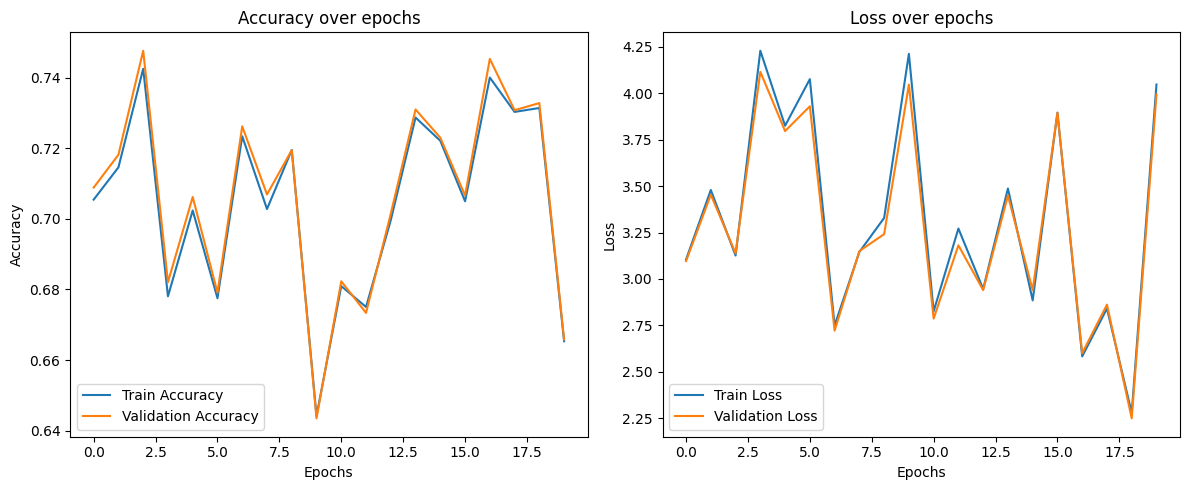

2024-10-10 05:02:15,263 - INFO - Testing Results:
2024-10-10 05:02:15,265 - INFO - Test Loss: 3.8464, Test Accuracy: 0.6699, 
2024-10-10 05:02:15,266 - INFO - Test ROC AUC: 0.9303, Precision: 1.0000, 
2024-10-10 05:02:15,267 - INFO - Recall: 0.1112, F1: 0.2001


Plot saved to: /kaggle/working/LinearSVC_training_validation_curves.png
Testing linear SVC Model
Test Loss: 3.8464, Test Accuracy: 0.6699, Test ROC AUC: 0.9303, Precision: 1.0000, Recall: 0.1112, F1: 0.2001
Training RNN Model
Model not found. Training a new model...
Epoch 1/20


I0000 00:00:1728536596.134246     126 service.cc:145] XLA service 0x7efb441a6280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728536596.134319     126 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728536596.326770     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1262/1262 [==============================] - 129s 63ms/step - loss: 0.2003 - accuracy: 0.8990 - auc: 0.9026 - val_loss: 0.0672 - val_accuracy: 0.9785 - val_auc: 0.9793
Epoch 2/20
1262/1262 [==============================] - 59s 47ms/step - loss: 0.0541 - accuracy: 0.9822 - auc: 0.9823 - val_loss: 0.0585 - val_accuracy: 0.9814 - val_auc: 0.9833
Epoch 3/20
1262/1262 [==============================] - 59s 47ms/step - loss: 0.0417 - accuracy: 0.9866 - auc: 0.9866 - val_loss: 0.0552 - val_accuracy: 0.9841 - val_auc: 0.9848
Epoch 4/20
1262/1262 [==============================] - 60s 48ms/step - loss: 0.0366 - accuracy: 0.9887 - auc: 0.9884 - val_loss: 0.0495 - val_accuracy: 0.9840 - val_auc: 0.9828
Epoch 5/20
1262/1262 [==============================] - 60s 48ms/step - loss: 0.0340 - accuracy: 0.9891 - auc: 0.9892 - val_loss: 0.0531 - val_accuracy: 0.9845 - val_auc: 0.9839
Epoch 6/20
1262/1262 [==============================] - 60s 47ms/step - loss: 0.0329 - accuracy: 0.9899 - auc: 0.9896 - 

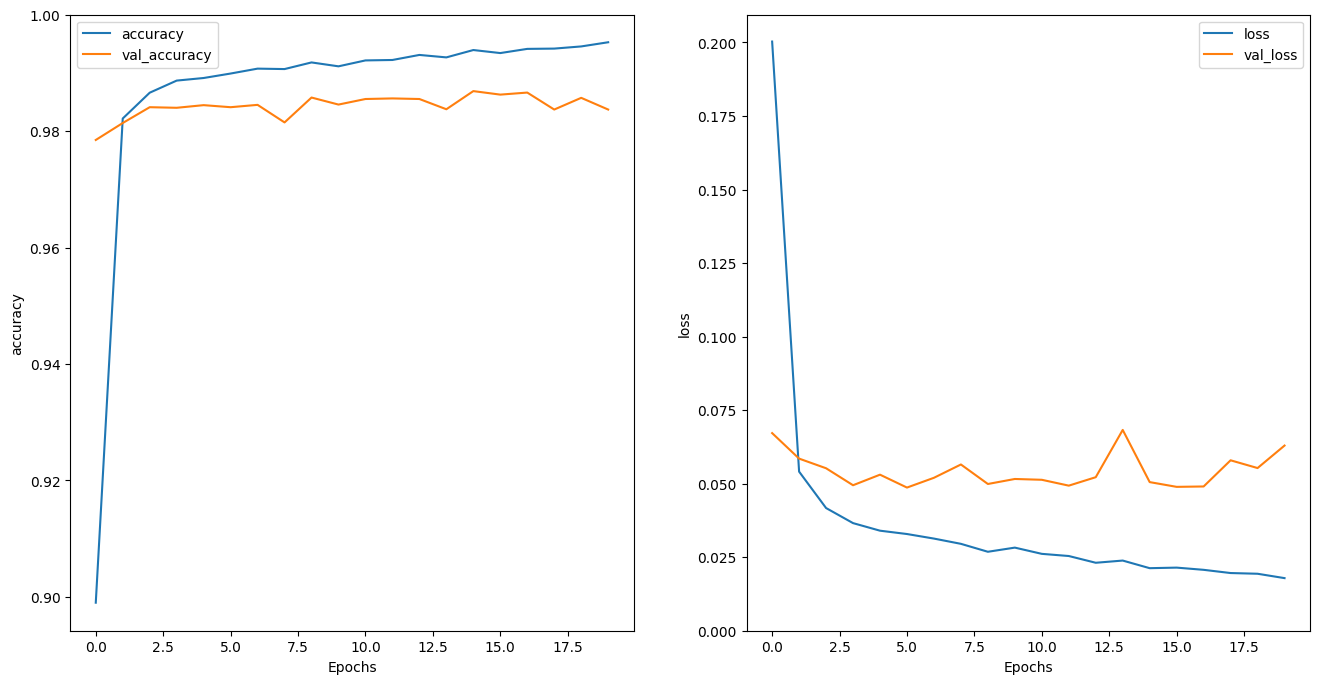

Testing RNN Model
Loading model from file...
471/471 [==============================] - 14s 18ms/step


2024-10-10 05:23:46,197 - INFO - Testing Results:
2024-10-10 05:23:46,198 - INFO - Test Loss: 0.0694, Test Accuracy: 0.9829, 
2024-10-10 05:23:46,199 - INFO - Test ROC AUC: 0.9975, Precision: 0.9878, 
2024-10-10 05:23:46,201 - INFO - Recall: 0.9660, F1: 0.9768


Test Loss: 0.0694, Test Accuracy: 0.9829, Test ROC AUC: 0.9975, Precision: 0.9878, Recall: 0.9660, F1: 0.9768
Training DistilBERT Model
Model not found. Training a new model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40382 [00:00<?, ? examples/s]

Map:   0%|          | 0/19890 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 33.12 MiB is free. Process 2945 has 15.85 GiB memory in use. Of the allocated memory 355.16 MiB is allocated by PyTorch, and 30.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
def main():
    # Khởi tạo số luồng xử lý song song
    # max_workers = 1 
    
    # kaggle 
    in_base_path = r"/kaggle/input/dath-pdz/"
    out_base_path = r"/kaggle/working/"
    
    # in_base_path = r"E:\2_LEARNING_BKU\2_File_2\K22_HK241\CO3101_Do_an_Tri_tue_nhan_tao\Main\Dataset"
    # out_base_path = r"E:\2_LEARNING_BKU\2_File_2\K22_HK241\CO3101_Do_an_Tri_tue_nhan_tao\Output"   # đường dẫn gốc tới folder
    
    # Fix the file path by adding the missing backslash or using os.path.join
    file_name = os.path.join(in_base_path, 'final_dataset_v1_afternb1.csv')  # Correct file path
    
    # Bắt đầu theo dõi thời gian
    t_start_time = time.time()
    
    # Load and preprocess data
    df_ds, train_essays, test_essays, val_essays = load_data(file_name)
    
    # Check the size of each set
    print(f'Full set size: {len(df_ds)}')
    print(f'Training set size: {len(train_essays)}')
    print(f'Validation set size: {len(val_essays)}')
    print(f'Test set size: {len(test_essays)}')

    # ============================================================================================
    # Load the glove model
    word2vec_output_file = get_tmpfile(r"/kaggle/input/pdz-dath-ds/output_w2v.txt")
    # word2vec_output_file = get_tmpfile(r"E:\2_LEARNING_BKU\2_File_2\K22_HK241\CO3101_Do_an_Tri_tue_nhan_tao\Main\Dataset\output_w2v.txt")
    glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

    # Prepare train and validation embeddings
    X_train = train_essays['processed_text_swr'].tolist()
    X_val = val_essays['processed_text_swr'].tolist()
    y_train = train_essays['label'].values
    y_val = val_essays['label'].values
    
    # Prepare test data
    X_test = test_essays['processed_text_swr'].tolist()
    y_test = test_essays['label'].values
    
    # Embedding these information dataset
    X_train_embeddings = np.array([sent2vec(sent, glove_model) for sent in X_train])
    X_val_embeddings = np.array([sent2vec(sent, glove_model) for sent in X_val])
    
    X_test_embeddings = np.array([sent2vec(sent, glove_model) for sent in X_test])
    # ============================================================================================

    # Train the Logistic Regression model using the train and validation sets
    logistic_model_file_path = os.path.join(out_base_path, 'logistic_regression_model.pkl')
    train_logistic_regression(X_train_embeddings, y_train, X_val_embeddings, y_val, logistic_model_file_path, out_base_path)

    # Test the Logistic Regression model on the test set
    print("Testing Logistic Regression Model")
    test_model(X_test_embeddings, y_test, logistic_model_file_path)
    # ============================================================================================

    # Train the XGBoost model using the train and validation sets
    xgboost_model_file_path = os.path.join(out_base_path, 'xgboost_model.pkl')
    train_xgboost(X_train_embeddings, y_train, X_val_embeddings, y_val, xgboost_model_file_path, out_base_path)

    # Test the XGBoost model on the test set
    print("Testing XGBoost Model")
    test_model(X_test_embeddings, y_test, xgboost_model_file_path)
    # ============================================================================================
    
    # Train the Random Forest model using the train and validation sets
    randomforest_model_file_path = os.path.join(out_base_path, 'randomforest_model.pkl')
    train_random_forest(X_train_embeddings, y_train, X_val_embeddings, y_val, randomforest_model_file_path, out_base_path)

    # Test the Random Forest model on the test set
    print("Testing Random Forest Model")
    test_model(X_test_embeddings, y_test, randomforest_model_file_path)
    
    
    # ============================================================================================
    
    # Train the Linear SVC model using the train and validation sets
    linear_svc_model_file_path = os.path.join(out_base_path, 'linearsvc_model.pkl')
    train_linear_svc(X_train_embeddings, y_train, X_val_embeddings, y_val, linear_svc_model_file_path, out_base_path)

    # Test the Linear SVC model on the test set
    print("Testing linear SVC Model")
    test_linearsvc(X_test_embeddings, y_test, linear_svc_model_file_path)
    
    
    # ============================================================================================
    # Train the Bidirectional LSTM RNN model using the train and validation sets
    rnn_model_file_path = os.path.join(out_base_path, 'tf_lstm_rnn.keras')
    rnn_plot_file_path = os.path.join(out_base_path, 'tf_lstm_rnn.png')

    print("Training RNN Model")
    train_rnn(X_train, y_train, X_val, y_val, rnn_model_file_path, rnn_plot_file_path, n_epochs=20, batch_size=32)

    # Test the RNN model on the test set
    print("Testing RNN Model")
    test_rnn(X_test, y_test, rnn_model_file_path)

    # ============================================================================================

    # distilbert_model_path = os.path.join(out_base_path, 'distilbert_model')  # Use folder path without file extension
    # distilbert_plot_file_path = os.path.join(out_base_path, 'distilbert_training_plot.png')

    # print("Training DistilBERT Model")
    # train_distilbert(df_ds, distilbert_model_path, distilbert_plot_file_path, n_epochs=10)

    # # Test the DistilBERT model on the test set
    # print("Testing DistilBERT Model")
    # test_distilbert(test_essays, distilbert_model_path)

    # ============================================================================================
    
    # Kết thúc theo dõi thời gian
    t_end_time = time.time()
    t_processing_time = t_end_time - t_start_time

    # Convert minutes to hours and minutes
    t_hours = int(t_processing_time // 3600)  # Lấy số giờ
    t_minutes = int((t_processing_time % 3600) // 60)  # Lấy số phút
    t_seconds = int(t_processing_time % 60)  # Lấy số giây

    logger.log_message(f"Finished processing (total) in {t_hours} hours, {t_minutes} minutes, {t_seconds} seconds")       

if __name__ == "__main__":  
    main()


In [ ]:
# !rm -rf /kaggle/working/*

In [ ]:
# !zip -r file.zip /kaggle/working